In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.interpolate import interp1d
from tqdm import tqdm
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore')

In [ ]:
import zipfile
with zipfile.ZipFile('/content/AIS_2022_03_31.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [ ]:
df = pd.read_csv('/content/AIS_2022_03_31.csv',nrows=20000)
df.head()

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TransceiverClass
0,367702220,2022-03-31T00:00:01,29.78763,-95.08070,0.1,226.5,340.0,JOE B WARD,NaN,WDI4808,31.0,12.0,21.0,8.0,NaN,57.0,A
1,671226100,2022-03-31T00:00:01,25.77626,-80.20320,3.2,143.7,511.0,RELIANCE II,IMO9221322,5VHS7,79.0,0.0,52.0,12.0,2.5,70.0,A
2,367767250,2022-03-31T00:00:01,29.31623,-94.78829,4.5,228.1,511.0,GLEN K,NaN,WDJ3358,52.0,0.0,0.0,0.0,0.0,52.0,A
3,338327436,2022-03-31T00:00:03,47.29634,-122.42233,0.0,360.0,511.0,COOL KAT,IMO0000000,NaN,36.0,NaN,15.0,3.0,NaN,NaN,B
4,367452810,2022-03-31T00:00:06,29.32824,-94.77391,2.6,319.2,511.0,JOHN W JOHNSON,IMO9602344,WDF4516,60.0,0.0,80.0,19.0,3.0,60.0,A


In [ ]:
df = df[['BaseDateTime', 'MMSI', 'LAT', 'LON', 'SOG']]
df.head()

,BaseDateTime,MMSI,LAT,LON,SOG
0,2022-03-31T00:00:01,367702220,29.78763,-95.08070,0.1
1,2022-03-31T00:00:01,671226100,25.77626,-80.20320,3.2
2,2022-03-31T00:00:01,367767250,29.31623,-94.78829,4.5
3,2022-03-31T00:00:03,338327436,47.29634,-122.42233,0.0
4,2022-03-31T00:00:06,367452810,29.32824,-94.77391,2.6


In [ ]:

def lat_lon_range(df_file):
    """
    Calculate the bounding box for latitude and longitude.

    Parameters:
    - df_file: DataFrame containing 'LAT' and 'LON' columns.

    Returns:
    - min_lat, max_lat, min_lon, max_lon: Integer values defining the bounding box.
    """
    min_lat, max_lat = df_file['LAT'].min(), df_file['LAT'].max()
    min_lon, max_lon = df_file['LON'].min(), df_file['LON'].max()
    min_lat, max_lat, min_lon, max_lon = (
        int(np.floor(min_lat)),
        int(np.ceil(max_lat)),
        int(np.floor(min_lon)),
        int(np.ceil(max_lon)),
    )
    return min_lat, max_lat, min_lon, max_lon


def sliding_window_segmentation(data, window_size, step_size, mmsi):
    """
    Perform sliding window segmentation on the given DataFrame.

    Parameters:
    - data: Pandas DataFrame containing the trajectory.
    - window_size: The number of data points in each sliding window.
    - step_size: The step size for the sliding window.
    - mmsi: MMSI of the vessel for this segment.

    Returns:
    - segments: A list of DataFrames, each representing a segmented window.
    """
    segments = []
    for start in range(0, len(data) - window_size + 1, step_size):
        window = data.iloc[start:start + window_size].copy()
        window['MMSI'] = mmsi  # Explicitly set MMSI for each segment
        segments.append(window)
    return segments


def prepare_ais_data_with_sliding_window_with_onehot_en(
    data, bounding_box, window_size, step_size, resample_interval=10
):
    """
    Prepare AIS data using sliding window segmentation.

    Parameters:
    - data: Pandas DataFrame containing AIS data.
    - bounding_box: Tuple defining the bounding box (min_lat, max_lat, min_lon, max_lon).
    - window_size: The number of data points in each sliding window.
    - step_size: The step size for the sliding window.
    - resample_interval: Resampling interval in seconds.

    Returns:
    - combined_df: A single DataFrame containing all segmented trajectories.
    """
    min_lat, max_lat, min_lon, max_lon = bounding_box

    # Step 1: Apply bounding box filter
    filtered_data = data[
        (data['LAT'] >= min_lat) & (data['LAT'] <= max_lat) &
        (data['LON'] >= min_lon) & (data['LON'] <= max_lon)
    ]

    # Step 2: Aggregate by MMSI and sort by timestamp
    grouped = filtered_data.groupby('MMSI')
    segments = []
    segment_id = 0

    # Step 3: Process each MMSI group
    for mmsi, group in tqdm(grouped, desc="Processing MMSI", unit="MMSI"):
        group = group.sort_values(by='BaseDateTime')
        group['BaseDateTime'] = pd.to_datetime(group['BaseDateTime'])

        # Step 4: Resample data
        timestamps = group['BaseDateTime']
        latitudes = group['LAT']
        longitudes = group['LON']
        sog = group['SOG']

        if len(timestamps) < 2:
            print(f"Skipping MMSI {mmsi} due to insufficient data points")
            continue

        # Generate new timestamps for resampling
        start_time = timestamps.iloc[0]
        end_time = timestamps.iloc[-1]
        new_timestamps = pd.date_range(start=start_time, end=end_time, freq=f'{resample_interval}S')

        # Interpolation
        interp_lat = interp1d(
            timestamps.astype(np.int64), latitudes, kind='linear', bounds_error=False, fill_value="extrapolate"
        )
        interp_lon = interp1d(
            timestamps.astype(np.int64), longitudes, kind='linear', bounds_error=False, fill_value="extrapolate"
        )
        interp_sog = interp1d(
            timestamps.astype(np.int64), sog, kind='linear', bounds_error=False, fill_value="extrapolate"
        )

        resampled_traj = pd.DataFrame({
            'BaseDateTime': new_timestamps,
            'LAT': interp_lat(new_timestamps.astype(np.int64)),
            'LON': interp_lon(new_timestamps.astype(np.int64)),
            'SOG': interp_sog(new_timestamps.astype(np.int64)),
        })

        # Perform sliding window segmentation
        trajectory_segments = sliding_window_segmentation(resampled_traj, window_size, step_size, mmsi)

        for segment in trajectory_segments:
            segment['SegmentID'] = segment_id
            segments.append(segment)
            segment_id += 1

    # Combine all segmented trajectories into a single DataFrame
    combined_df = pd.concat(segments, ignore_index=True)
    return combined_df




In [ ]:
# Calculate bounding box
min_lat, max_lat, min_lon, max_lon = lat_lon_range(df)
bounding_box = (min_lat, max_lat, min_lon, max_lon)

# Define window size and step size
window_size = 10
step_size = 5

# Process AIS data
segmented_trajectories_df = prepare_ais_data_with_sliding_window_with_onehot_en(
    df, bounding_box, window_size, step_size
)

segmented_trajectories_df.to_csv('./segmented_trajectories.csv', index=False)
print("Segmentation completed and saved to 'segmented_trajectories.csv'")

Processing MMSI:   1%|          | 42/7555 [00:00<00:36, 205.28MMSI/s]

Skipping MMSI 209316000 due to insufficient data points
Skipping MMSI 209615000 due to insufficient data points
Skipping MMSI 209641000 due to insufficient data points
Skipping MMSI 210959000 due to insufficient data points
Skipping MMSI 211002010 due to insufficient data points
Skipping MMSI 211334250 due to insufficient data points
Skipping MMSI 211664910 due to insufficient data points
Skipping MMSI 211711990 due to insufficient data points
Skipping MMSI 211839000 due to insufficient data points
Skipping MMSI 212210000 due to insufficient data points
Skipping MMSI 212254000 due to insufficient data points
Skipping MMSI 212282000 due to insufficient data points
Skipping MMSI 212347000 due to insufficient data points
Skipping MMSI 215154000 due to insufficient data points
Skipping MMSI 215464000 due to insufficient data points


Processing MMSI:   1%|          | 87/7555 [00:00<00:35, 208.58MMSI/s]

Skipping MMSI 218643000 due to insufficient data points
Skipping MMSI 218774000 due to insufficient data points
Skipping MMSI 219227000 due to insufficient data points
Skipping MMSI 219265000 due to insufficient data points
Skipping MMSI 219278000 due to insufficient data points
Skipping MMSI 219310000 due to insufficient data points
Skipping MMSI 219426000 due to insufficient data points
Skipping MMSI 219683000 due to insufficient data points
Skipping MMSI 220258000 due to insufficient data points
Skipping MMSI 226235000 due to insufficient data points
Skipping MMSI 227081410 due to insufficient data points
Skipping MMSI 227109660 due to insufficient data points
Skipping MMSI 227533980 due to insufficient data points
Skipping MMSI 227813010 due to insufficient data points
Skipping MMSI 228078350 due to insufficient data points
Skipping MMSI 228408700 due to insufficient data points
Skipping MMSI 229373000 due to insufficient data points
Skipping MMSI 229376000 due to insufficient data

Processing MMSI:   2%|▏         | 134/7555 [00:00<00:34, 214.92MMSI/s]

Skipping MMSI 232012490 due to insufficient data points
Skipping MMSI 232018309 due to insufficient data points
Skipping MMSI 232026262 due to insufficient data points
Skipping MMSI 232027226 due to insufficient data points
Skipping MMSI 232031599 due to insufficient data points
Skipping MMSI 232032072 due to insufficient data points
Skipping MMSI 232038795 due to insufficient data points
Skipping MMSI 232038796 due to insufficient data points
Skipping MMSI 232039262 due to insufficient data points
Skipping MMSI 232039370 due to insufficient data points
Skipping MMSI 233387000 due to insufficient data points
Skipping MMSI 233731000 due to insufficient data points
Skipping MMSI 235072538 due to insufficient data points
Skipping MMSI 235076272 due to insufficient data points
Skipping MMSI 235076274 due to insufficient data points
Skipping MMSI 235085287 due to insufficient data points
Skipping MMSI 235085999 due to insufficient data points
Skipping MMSI 235088016 due to insufficient data

Processing MMSI:   2%|▏         | 156/7555 [00:00<00:39, 189.49MMSI/s]

Skipping MMSI 240480000 due to insufficient data points
Skipping MMSI 240904000 due to insufficient data points
Skipping MMSI 241473000 due to insufficient data points
Skipping MMSI 241508000 due to insufficient data points
Skipping MMSI 244650099 due to insufficient data points
Skipping MMSI 245227000 due to insufficient data points
Skipping MMSI 245854000 due to insufficient data points
Skipping MMSI 246770000 due to insufficient data points


Processing MMSI:   3%|▎         | 216/7555 [00:01<00:39, 185.17MMSI/s]

Skipping MMSI 248567000 due to insufficient data points
Skipping MMSI 248713000 due to insufficient data points
Skipping MMSI 248741000 due to insufficient data points
Skipping MMSI 249048000 due to insufficient data points
Skipping MMSI 249111000 due to insufficient data points
Skipping MMSI 249335000 due to insufficient data points
Skipping MMSI 255728000 due to insufficient data points
Skipping MMSI 255805573 due to insufficient data points
Skipping MMSI 255805662 due to insufficient data points
Skipping MMSI 255805665 due to insufficient data points
Skipping MMSI 255805979 due to insufficient data points
Skipping MMSI 255806037 due to insufficient data points
Skipping MMSI 255806059 due to insufficient data points
Skipping MMSI 255806122 due to insufficient data points
Skipping MMSI 255806371 due to insufficient data points
Skipping MMSI 255806448 due to insufficient data points
Skipping MMSI 255806483 due to insufficient data points
Skipping MMSI 256001528 due to insufficient data

Processing MMSI:   3%|▎         | 254/7555 [00:01<00:39, 183.52MMSI/s]

Skipping MMSI 256687000 due to insufficient data points
Skipping MMSI 257020120 due to insufficient data points
Skipping MMSI 257076640 due to insufficient data points
Skipping MMSI 257344000 due to insufficient data points
Skipping MMSI 257484000 due to insufficient data points
Skipping MMSI 257682000 due to insufficient data points
Skipping MMSI 257724000 due to insufficient data points
Skipping MMSI 258775000 due to insufficient data points
Skipping MMSI 258795000 due to insufficient data points
Skipping MMSI 259890000 due to insufficient data points


Processing MMSI:   4%|▍         | 292/7555 [00:01<00:39, 182.56MMSI/s]

Skipping MMSI 265816730 due to insufficient data points
Skipping MMSI 269110620 due to insufficient data points
Skipping MMSI 271043022 due to insufficient data points
Skipping MMSI 303104000 due to insufficient data points
Skipping MMSI 303155000 due to insufficient data points
Skipping MMSI 303198000 due to insufficient data points
Skipping MMSI 303327000 due to insufficient data points
Skipping MMSI 303334000 due to insufficient data points
Skipping MMSI 303350200 due to insufficient data points
Skipping MMSI 303455000 due to insufficient data points
Skipping MMSI 303476000 due to insufficient data points
Skipping MMSI 303532000 due to insufficient data points
Skipping MMSI 303679000 due to insufficient data points
Skipping MMSI 303867000 due to insufficient data points

Processing MMSI:   4%|▍         | 330/7555 [00:01<00:39, 181.43MMSI/s]


Skipping MMSI 303999000 due to insufficient data points
Skipping MMSI 304067000 due to insufficient data points
Skipping MMSI 304941000 due to insufficient data points
Skipping MMSI 305066000 due to insufficient data points
Skipping MMSI 305134000 due to insufficient data points
Skipping MMSI 305140000 due to insufficient data points
Skipping MMSI 305767000 due to insufficient data points
Skipping MMSI 308077000 due to insufficient data points
Skipping MMSI 308371000 due to insufficient data points
Skipping MMSI 308865000 due to insufficient data points
Skipping MMSI 309168000 due to insufficient data points
Skipping MMSI 309653000 due to insufficient data points
Skipping MMSI 310376000 due to insufficient data points
Skipping MMSI 310563000 due to insufficient data points


Processing MMSI:   5%|▍         | 371/7555 [00:01<00:40, 178.56MMSI/s]

Skipping MMSI 310806000 due to insufficient data points
Skipping MMSI 310829000 due to insufficient data points
Skipping MMSI 310996191 due to insufficient data points
Skipping MMSI 311000106 due to insufficient data points
Skipping MMSI 311000112 due to insufficient data points
Skipping MMSI 311000221 due to insufficient data points
Skipping MMSI 311000247 due to insufficient data points
Skipping MMSI 311000327 due to insufficient data points
Skipping MMSI 311000384 due to insufficient data points
Skipping MMSI 311000617 due to insufficient data points
Skipping MMSI 311000756 due to insufficient data points
Skipping MMSI 311000877 due to insufficient data points
Skipping MMSI 311001057 due to insufficient data points


Processing MMSI:   5%|▌         | 393/7555 [00:02<00:37, 189.56MMSI/s]

Skipping MMSI 311001104 due to insufficient data points
Skipping MMSI 311003200 due to insufficient data points
Skipping MMSI 311007500 due to insufficient data points
Skipping MMSI 311018700 due to insufficient data points
Skipping MMSI 311042900 due to insufficient data points
Skipping MMSI 311050300 due to insufficient data points
Skipping MMSI 311060500 due to insufficient data points
Skipping MMSI 311728000 due to insufficient data points
Skipping MMSI 311733000 due to insufficient data points
Skipping MMSI 311831000 due to insufficient data points
Skipping MMSI 314444000 due to insufficient data points
Skipping MMSI 314447000 due to insufficient data points
Skipping MMSI 316001005 due to insufficient data points
Skipping MMSI 316001028 due to insufficient data points
Skipping MMSI 316001232 due to insufficient data points
Skipping MMSI 316001255 due to insufficient data points
Skipping MMSI 316001262 due to insufficient data points


Processing MMSI:   6%|▌         | 450/7555 [00:02<00:42, 168.38MMSI/s]

Skipping MMSI 316001481 due to insufficient data points
Skipping MMSI 316001659 due to insufficient data points
Skipping MMSI 316001717 due to insufficient data points
Skipping MMSI 316001759 due to insufficient data points
Skipping MMSI 316002054 due to insufficient data points
Skipping MMSI 316002294 due to insufficient data points
Skipping MMSI 316003250 due to insufficient data points
Skipping MMSI 316003702 due to insufficient data points


Processing MMSI:   6%|▌         | 468/7555 [00:02<00:42, 165.04MMSI/s]

Skipping MMSI 316004106 due to insufficient data points
Skipping MMSI 316004410 due to insufficient data points
Skipping MMSI 316004946 due to insufficient data points
Skipping MMSI 316005204 due to insufficient data points
Skipping MMSI 316005337 due to insufficient data points


Processing MMSI:   7%|▋         | 539/7555 [00:02<00:35, 199.88MMSI/s]

Skipping MMSI 316005819 due to insufficient data points
Skipping MMSI 316006163 due to insufficient data points
Skipping MMSI 316007017 due to insufficient data points
Skipping MMSI 316007571 due to insufficient data points
Skipping MMSI 316007636 due to insufficient data points
Skipping MMSI 316007928 due to insufficient data points
Skipping MMSI 316008190 due to insufficient data points
Skipping MMSI 316008380 due to insufficient data points
Skipping MMSI 316008779 due to insufficient data points
Skipping MMSI 316009004 due to insufficient data points
Skipping MMSI 316010192 due to insufficient data points
Skipping MMSI 316010312 due to insufficient data points
Skipping MMSI 316011299 due to insufficient data points
Skipping MMSI 316011407 due to insufficient data points
Skipping MMSI 316011409 due to insufficient data points
Skipping MMSI 316012406 due to insufficient data points
Skipping MMSI 316013209 due to insufficient data points


Processing MMSI:   7%|▋         | 563/7555 [00:03<00:33, 209.72MMSI/s]

Skipping MMSI 316013512 due to insufficient data points
Skipping MMSI 316013544 due to insufficient data points
Skipping MMSI 316013809 due to insufficient data points
Skipping MMSI 316013980 due to insufficient data points
Skipping MMSI 316015284 due to insufficient data points
Skipping MMSI 316015747 due to insufficient data points
Skipping MMSI 316017034 due to insufficient data points
Skipping MMSI 316017058 due to insufficient data points
Skipping MMSI 316017089 due to insufficient data points
Skipping MMSI 316018117 due to insufficient data points
Skipping MMSI 316018772 due to insufficient data points
Skipping MMSI 316018816 due to insufficient data points
Skipping MMSI 316020742 due to insufficient data points


Exception ignored in: <function tqdm.__del__ at 0x7f557b4e1900>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/usr/local/lib/python3.10/dist-packages/tqdm/std.py", line 1277, in close
    if self.last_print_t < self.start_t + self.delay:
AttributeError: 'tqdm' object has no attribute 'last_print_t'
Processing MMSI:   9%|▊         | 648/7555 [00:03<00:34, 200.84MMSI/s]

Skipping MMSI 316020871 due to insufficient data points
Skipping MMSI 316021184 due to insufficient data points
Skipping MMSI 316021192 due to insufficient data points
Skipping MMSI 316021215 due to insufficient data points
Skipping MMSI 316021247 due to insufficient data points
Skipping MMSI 316021351 due to insufficient data points
Skipping MMSI 316021385 due to insufficient data points
Skipping MMSI 316021522 due to insufficient data points
Skipping MMSI 316021813 due to insufficient data points
Skipping MMSI 316022229 due to insufficient data points
Skipping MMSI 316022594 due to insufficient data points
Skipping MMSI 316023763 due to insufficient data points
Skipping MMSI 316023945 due to insufficient data points
Skipping MMSI 316024728 due to insufficient data points
Skipping MMSI 316024998 due to insufficient data points
Skipping MMSI 316026125 due to insufficient data points
Skipping MMSI 316026257 due to insufficient data points
Skipping MMSI 316027000 due to insufficient data

Processing MMSI:   9%|▉         | 711/7555 [00:03<00:27, 251.72MMSI/s]

Skipping MMSI 316028897 due to insufficient data points
Skipping MMSI 316029379 due to insufficient data points
Skipping MMSI 316029551 due to insufficient data points
Skipping MMSI 316030053 due to insufficient data points
Skipping MMSI 316030138 due to insufficient data points
Skipping MMSI 316030165 due to insufficient data points
Skipping MMSI 316030507 due to insufficient data points
Skipping MMSI 316030628 due to insufficient data points
Skipping MMSI 316030636 due to insufficient data points
Skipping MMSI 316030839 due to insufficient data points
Skipping MMSI 316031573 due to insufficient data points
Skipping MMSI 316031782 due to insufficient data points
Skipping MMSI 316031939 due to insufficient data points
Skipping MMSI 316032000 due to insufficient data points
Skipping MMSI 316032638 due to insufficient data points
Skipping MMSI 316032784 due to insufficient data points
Skipping MMSI 316033381 due to insufficient data points
Skipping MMSI 316033461 due to insufficient data

Processing MMSI:  10%|█         | 783/7555 [00:03<00:22, 297.09MMSI/s]

Skipping MMSI 316038839 due to insufficient data points
Skipping MMSI 316038841 due to insufficient data points
Skipping MMSI 316039171 due to insufficient data points
Skipping MMSI 316039185 due to insufficient data points
Skipping MMSI 316039229 due to insufficient data points
Skipping MMSI 316039361 due to insufficient data points
Skipping MMSI 316039457 due to insufficient data points
Skipping MMSI 316040059 due to insufficient data points
Skipping MMSI 316040219 due to insufficient data points
Skipping MMSI 316040287 due to insufficient data points
Skipping MMSI 316040486 due to insufficient data points
Skipping MMSI 316040584 due to insufficient data points
Skipping MMSI 316040645 due to insufficient data points
Skipping MMSI 316041207 due to insufficient data points
Skipping MMSI 316041231 due to insufficient data points
Skipping MMSI 316041247 due to insufficient data points
Skipping MMSI 316041391 due to insufficient data points
Skipping MMSI 316041723 due to insufficient data

Processing MMSI:  11%|█▏        | 858/7555 [00:04<00:20, 329.65MMSI/s]

Skipping MMSI 316046759 due to insufficient data points
Skipping MMSI 316046886 due to insufficient data points
Skipping MMSI 316046934 due to insufficient data points
Skipping MMSI 316047053 due to insufficient data points
Skipping MMSI 316047155 due to insufficient data points
Skipping MMSI 316047268 due to insufficient data points
Skipping MMSI 316047434 due to insufficient data points
Skipping MMSI 316047682 due to insufficient data points
Skipping MMSI 316047772 due to insufficient data points
Skipping MMSI 316047778 due to insufficient data points
Skipping MMSI 316047826 due to insufficient data points
Skipping MMSI 316047894 due to insufficient data points
Skipping MMSI 316047896 due to insufficient data points
Skipping MMSI 316047926 due to insufficient data points
Skipping MMSI 316047943 due to insufficient data points
Skipping MMSI 316051000 due to insufficient data points
Skipping MMSI 316114000 due to insufficient data points
Skipping MMSI 316115000 due to insufficient data

Processing MMSI:  12%|█▏        | 925/7555 [00:04<00:20, 320.46MMSI/s]

Skipping MMSI 319125200 due to insufficient data points
Skipping MMSI 319129300 due to insufficient data points
Skipping MMSI 319130200 due to insufficient data points
Skipping MMSI 319136300 due to insufficient data points
Skipping MMSI 319136500 due to insufficient data points
Skipping MMSI 319143600 due to insufficient data points
Skipping MMSI 319147800 due to insufficient data points
Skipping MMSI 319156800 due to insufficient data points
Skipping MMSI 319167500 due to insufficient data points
Skipping MMSI 319172900 due to insufficient data points
Skipping MMSI 319179500 due to insufficient data points
Skipping MMSI 319180300 due to insufficient data points
Skipping MMSI 319180800 due to insufficient data points
Skipping MMSI 319181000 due to insufficient data points
Skipping MMSI 319196400 due to insufficient data points
Skipping MMSI 319205400 due to insufficient data points
Skipping MMSI 319208100 due to insufficient data points
Skipping MMSI 319210900 due to insufficient data

Processing MMSI:  13%|█▎        | 993/7555 [00:04<00:20, 321.31MMSI/s]

Skipping MMSI 319515000 due to insufficient data points
Skipping MMSI 319567000 due to insufficient data points
Skipping MMSI 319589000 due to insufficient data points
Skipping MMSI 319597000 due to insufficient data points
Skipping MMSI 319662000 due to insufficient data points
Skipping MMSI 319669000 due to insufficient data points
Skipping MMSI 319793000 due to insufficient data points
Skipping MMSI 319795000 due to insufficient data points
Skipping MMSI 319869000 due to insufficient data points
Skipping MMSI 319983000 due to insufficient data points
Skipping MMSI 327801008 due to insufficient data points
Skipping MMSI 329696389 due to insufficient data points
Skipping MMSI 338000083 due to insufficient data points
Skipping MMSI 338002000 due to insufficient data points
Skipping MMSI 338003759 due to insufficient data points
Skipping MMSI 338032000 due to insufficient data points
Skipping MMSI 338032925 due to insufficient data points
Skipping MMSI 338034319 due to insufficient data

Processing MMSI:  14%|█▍        | 1064/7555 [00:04<00:19, 335.08MMSI/s]

Skipping MMSI 338070466 due to insufficient data points
Skipping MMSI 338070931 due to insufficient data points
Skipping MMSI 338072235 due to insufficient data points
Skipping MMSI 338073736 due to insufficient data points
Skipping MMSI 338073787 due to insufficient data points
Skipping MMSI 338082912 due to insufficient data points
Skipping MMSI 338085017 due to insufficient data points
Skipping MMSI 338085738 due to insufficient data points
Skipping MMSI 338092145 due to insufficient data points
Skipping MMSI 338092678 due to insufficient data points
Skipping MMSI 338094819 due to insufficient data points
Skipping MMSI 338096168 due to insufficient data points
Skipping MMSI 338097196 due to insufficient data points
Skipping MMSI 338097908 due to insufficient data points
Skipping MMSI 338098154 due to insufficient data points
Skipping MMSI 338100071 due to insufficient data points
Skipping MMSI 338100112 due to insufficient data points
Skipping MMSI 338100519 due to insufficient data

Processing MMSI:  15%|█▌        | 1136/7555 [00:04<00:18, 346.37MMSI/s]

Skipping MMSI 338128636 due to insufficient data points
Skipping MMSI 338129119 due to insufficient data points
Skipping MMSI 338129197 due to insufficient data points
Skipping MMSI 338130079 due to insufficient data points
Skipping MMSI 338131743 due to insufficient data points
Skipping MMSI 338133464 due to insufficient data points
Skipping MMSI 338134237 due to insufficient data points
Skipping MMSI 338135872 due to insufficient data points
Skipping MMSI 338137048 due to insufficient data points
Skipping MMSI 338138014 due to insufficient data points
Skipping MMSI 338139285 due to insufficient data points
Skipping MMSI 338139678 due to insufficient data points
Skipping MMSI 338140403 due to insufficient data points
Skipping MMSI 338141819 due to insufficient data points
Skipping MMSI 338142000 due to insufficient data points
Skipping MMSI 338142951 due to insufficient data points
Skipping MMSI 338143743 due to insufficient data points
Skipping MMSI 338143945 due to insufficient data

Processing MMSI:  16%|█▌        | 1210/7555 [00:05<00:17, 358.52MMSI/s]

Skipping MMSI 338170062 due to insufficient data points
Skipping MMSI 338170444 due to insufficient data points
Skipping MMSI 338171551 due to insufficient data points
Skipping MMSI 338174473 due to insufficient data points
Skipping MMSI 338175814 due to insufficient data points
Skipping MMSI 338176511 due to insufficient data points
Skipping MMSI 338177403 due to insufficient data points
Skipping MMSI 338177821 due to insufficient data points
Skipping MMSI 338177881 due to insufficient data points
Skipping MMSI 338180905 due to insufficient data points
Skipping MMSI 338181202 due to insufficient data points
Skipping MMSI 338181537 due to insufficient data points
Skipping MMSI 338181762 due to insufficient data points
Skipping MMSI 338182138 due to insufficient data points
Skipping MMSI 338183059 due to insufficient data points
Skipping MMSI 338183078 due to insufficient data points
Skipping MMSI 338183549 due to insufficient data points
Skipping MMSI 338184011 due to insufficient data

Processing MMSI:  18%|█▊        | 1327/7555 [00:05<00:16, 369.33MMSI/s]

Skipping MMSI 338205376 due to insufficient data points
Skipping MMSI 338205644 due to insufficient data points
Skipping MMSI 338207479 due to insufficient data points
Skipping MMSI 338208483 due to insufficient data points
Skipping MMSI 338209202 due to insufficient data points
Skipping MMSI 338209286 due to insufficient data points
Skipping MMSI 338210856 due to insufficient data points
Skipping MMSI 338210969 due to insufficient data points
Skipping MMSI 338212484 due to insufficient data points
Skipping MMSI 338212734 due to insufficient data points
Skipping MMSI 338213453 due to insufficient data points
Skipping MMSI 338214613 due to insufficient data points
Skipping MMSI 338215000 due to insufficient data points
Skipping MMSI 338219167 due to insufficient data points
Skipping MMSI 338219251 due to insufficient data points
Skipping MMSI 338219285 due to insufficient data points
Skipping MMSI 338219658 due to insufficient data points
Skipping MMSI 338222414 due to insufficient data

Processing MMSI:  19%|█▊        | 1401/7555 [00:05<00:17, 361.20MMSI/s]

Skipping MMSI 338237928 due to insufficient data points
Skipping MMSI 338238828 due to insufficient data points
Skipping MMSI 338238922 due to insufficient data points
Skipping MMSI 338239395 due to insufficient data points
Skipping MMSI 338239419 due to insufficient data points
Skipping MMSI 338239429 due to insufficient data points
Skipping MMSI 338239613 due to insufficient data points
Skipping MMSI 338239883 due to insufficient data points
Skipping MMSI 338240138 due to insufficient data points
Skipping MMSI 338240821 due to insufficient data points
Skipping MMSI 338241769 due to insufficient data points
Skipping MMSI 338245332 due to insufficient data points
Skipping MMSI 338245604 due to insufficient data points
Skipping MMSI 338245991 due to insufficient data points
Skipping MMSI 338246829 due to insufficient data points
Skipping MMSI 338247491 due to insufficient data points
Skipping MMSI 338247984 due to insufficient data points
Skipping MMSI 338248304 due to insufficient data

Processing MMSI:  19%|█▉        | 1438/7555 [00:05<00:16, 361.67MMSI/s]

Skipping MMSI 338304847 due to insufficient data points
Skipping MMSI 338304968 due to insufficient data points
Skipping MMSI 338305000 due to insufficient data points
Skipping MMSI 338305462 due to insufficient data points
Skipping MMSI 338305827 due to insufficient data points
Skipping MMSI 338306518 due to insufficient data points
Skipping MMSI 338306841 due to insufficient data points
Skipping MMSI 338306884 due to insufficient data points
Skipping MMSI 338307005 due to insufficient data points
Skipping MMSI 338307324 due to insufficient data points
Skipping MMSI 338307615 due to insufficient data points
Skipping MMSI 338308018 due to insufficient data points
Skipping MMSI 338308619 due to insufficient data points
Skipping MMSI 338308639 due to insufficient data points
Skipping MMSI 338308963 due to insufficient data points
Skipping MMSI 338310228 due to insufficient data points
Skipping MMSI 338310272 due to insufficient data points
Skipping MMSI 338310281 due to insufficient data

Processing MMSI:  20%|█▉        | 1506/7555 [00:06<00:22, 265.67MMSI/s]

Skipping MMSI 338322986 due to insufficient data points
Skipping MMSI 338323002 due to insufficient data points
Skipping MMSI 338323386 due to insufficient data points
Skipping MMSI 338323974 due to insufficient data points
Skipping MMSI 338324193 due to insufficient data points
Skipping MMSI 338324589 due to insufficient data points
Skipping MMSI 338324914 due to insufficient data points
Skipping MMSI 338325344 due to insufficient data points
Skipping MMSI 338325347 due to insufficient data points
Skipping MMSI 338325605 due to insufficient data points
Skipping MMSI 338327129 due to insufficient data points
Skipping MMSI 338327314 due to insufficient data points
Skipping MMSI 338327396 due to insufficient data points
Skipping MMSI 338327402 due to insufficient data points
Skipping MMSI 338328344 due to insufficient data points
Skipping MMSI 338328696 due to insufficient data points
Skipping MMSI 338329217 due to insufficient data points
Skipping MMSI 338329372 due to insufficient data

Processing MMSI:  21%|██        | 1585/7555 [00:06<00:18, 322.32MMSI/s]

Skipping MMSI 338336533 due to insufficient data points
Skipping MMSI 338336608 due to insufficient data points
Skipping MMSI 338337916 due to insufficient data points
Skipping MMSI 338338006 due to insufficient data points
Skipping MMSI 338338317 due to insufficient data points
Skipping MMSI 338338944 due to insufficient data points
Skipping MMSI 338338998 due to insufficient data points
Skipping MMSI 338339427 due to insufficient data points
Skipping MMSI 338339596 due to insufficient data points
Skipping MMSI 338344036 due to insufficient data points
Skipping MMSI 338344194 due to insufficient data points
Skipping MMSI 338345000 due to insufficient data points
Skipping MMSI 338346695 due to insufficient data points
Skipping MMSI 338349894 due to insufficient data points
Skipping MMSI 338350431 due to insufficient data points
Skipping MMSI 338352047 due to insufficient data points
Skipping MMSI 338352087 due to insufficient data points
Skipping MMSI 338353022 due to insufficient data

Processing MMSI:  22%|██▏       | 1665/7555 [00:06<00:16, 354.37MMSI/s]

Skipping MMSI 338363141 due to insufficient data points
Skipping MMSI 338363874 due to insufficient data points
Skipping MMSI 338364108 due to insufficient data points
Skipping MMSI 338364773 due to insufficient data points
Skipping MMSI 338364987 due to insufficient data points
Skipping MMSI 338365526 due to insufficient data points
Skipping MMSI 338366542 due to insufficient data points
Skipping MMSI 338368108 due to insufficient data points
Skipping MMSI 338368555 due to insufficient data points
Skipping MMSI 338368627 due to insufficient data points
Skipping MMSI 338368763 due to insufficient data points
Skipping MMSI 338369005 due to insufficient data points
Skipping MMSI 338370861 due to insufficient data points
Skipping MMSI 338372404 due to insufficient data points
Skipping MMSI 338373465 due to insufficient data points
Skipping MMSI 338374911 due to insufficient data points
Skipping MMSI 338375118 due to insufficient data points
Skipping MMSI 338375599 due to insufficient data

Processing MMSI:  23%|██▎       | 1702/7555 [00:06<00:18, 317.98MMSI/s]

Skipping MMSI 338392718 due to insufficient data points
Skipping MMSI 338393034 due to insufficient data points
Skipping MMSI 338393413 due to insufficient data points
Skipping MMSI 338393461 due to insufficient data points
Skipping MMSI 338393576 due to insufficient data points
Skipping MMSI 338393673 due to insufficient data points
Skipping MMSI 338394312 due to insufficient data points
Skipping MMSI 338394396 due to insufficient data points
Skipping MMSI 338394436 due to insufficient data points
Skipping MMSI 338394494 due to insufficient data points
Skipping MMSI 338394942 due to insufficient data points
Skipping MMSI 338395001 due to insufficient data points
Skipping MMSI 338395156 due to insufficient data points
Skipping MMSI 338395165 due to insufficient data points
Skipping MMSI 338395731 due to insufficient data points
Skipping MMSI 338395953 due to insufficient data points
Skipping MMSI 338396317 due to insufficient data points
Skipping MMSI 338396738 due to insufficient data

Processing MMSI:  23%|██▎       | 1774/7555 [00:07<00:20, 278.39MMSI/s]

Skipping MMSI 338400039 due to insufficient data points
Skipping MMSI 338400091 due to insufficient data points
Skipping MMSI 338400219 due to insufficient data points
Skipping MMSI 338400236 due to insufficient data points
Skipping MMSI 338400249 due to insufficient data points
Skipping MMSI 338400725 due to insufficient data points
Skipping MMSI 338400879 due to insufficient data points
Skipping MMSI 338401259 due to insufficient data points
Skipping MMSI 338401492 due to insufficient data points
Skipping MMSI 338401543 due to insufficient data points
Skipping MMSI 338401888 due to insufficient data points
Skipping MMSI 338402699 due to insufficient data points
Skipping MMSI 338403681 due to insufficient data points
Skipping MMSI 338403988 due to insufficient data points
Skipping MMSI 338404083 due to insufficient data points
Skipping MMSI 338404181 due to insufficient data points
Skipping MMSI 338404311 due to insufficient data points
Skipping MMSI 338404572 due to insufficient data

Processing MMSI:  24%|██▍       | 1850/7555 [00:07<00:18, 314.93MMSI/s]

Skipping MMSI 338424196 due to insufficient data points
Skipping MMSI 338424903 due to insufficient data points
Skipping MMSI 338425088 due to insufficient data points
Skipping MMSI 338425161 due to insufficient data points
Skipping MMSI 338425576 due to insufficient data points
Skipping MMSI 338425803 due to insufficient data points
Skipping MMSI 338426024 due to insufficient data points
Skipping MMSI 338426331 due to insufficient data points
Skipping MMSI 338426476 due to insufficient data points
Skipping MMSI 338426776 due to insufficient data points
Skipping MMSI 338426928 due to insufficient data points
Skipping MMSI 338427125 due to insufficient data points
Skipping MMSI 338427291 due to insufficient data points
Skipping MMSI 338427408 due to insufficient data points
Skipping MMSI 338427733 due to insufficient data points
Skipping MMSI 338428031 due to insufficient data points
Skipping MMSI 338428065 due to insufficient data points
Skipping MMSI 338428281 due to insufficient data

Processing MMSI:  25%|██▌       | 1916/7555 [00:07<00:18, 303.31MMSI/s]

Skipping MMSI 338617000 due to insufficient data points
Skipping MMSI 338641000 due to insufficient data points
Skipping MMSI 338753000 due to insufficient data points
Skipping MMSI 338763000 due to insufficient data points
Skipping MMSI 338899000 due to insufficient data points
Skipping MMSI 338926418 due to insufficient data points
Skipping MMSI 338926425 due to insufficient data points
Skipping MMSI 338926448 due to insufficient data points
Skipping MMSI 338926449 due to insufficient data points
Skipping MMSI 339188000 due to insufficient data points
Skipping MMSI 339192000 due to insufficient data points
Skipping MMSI 339241000 due to insufficient data points
Skipping MMSI 339263000 due to insufficient data points
Skipping MMSI 339333000 due to insufficient data points
Skipping MMSI 339351000 due to insufficient data points
Skipping MMSI 339459000 due to insufficient data points
Skipping MMSI 339482000 due to insufficient data points
Skipping MMSI 339513000 due to insufficient data

Processing MMSI:  26%|██▌       | 1982/7555 [00:07<00:18, 299.86MMSI/s]

Skipping MMSI 339943000 due to insufficient data points
Skipping MMSI 339979000 due to insufficient data points
Skipping MMSI 341079000 due to insufficient data points
Skipping MMSI 341205000 due to insufficient data points
Skipping MMSI 345010030 due to insufficient data points
Skipping MMSI 345090011 due to insufficient data points
Skipping MMSI 351387000 due to insufficient data points
Skipping MMSI 351462000 due to insufficient data points
Skipping MMSI 351954000 due to insufficient data points
Skipping MMSI 352001121 due to insufficient data points
Skipping MMSI 352451000 due to insufficient data points
Skipping MMSI 352861000 due to insufficient data points
Skipping MMSI 352871000 due to insufficient data points
Skipping MMSI 352898749 due to insufficient data points
Skipping MMSI 352898775 due to insufficient data points
Skipping MMSI 353446000 due to insufficient data points
Skipping MMSI 353456000 due to insufficient data points
Skipping MMSI 353511000 due to insufficient data

Processing MMSI:  27%|██▋       | 2042/7555 [00:07<00:19, 278.59MMSI/s]

Skipping MMSI 355793000 due to insufficient data points
Skipping MMSI 356818000 due to insufficient data points
Skipping MMSI 356909000 due to insufficient data points
Skipping MMSI 357016000 due to insufficient data points
Skipping MMSI 357395000 due to insufficient data points
Skipping MMSI 357441000 due to insufficient data points
Skipping MMSI 357520610 due to insufficient data points
Skipping MMSI 357628000 due to insufficient data points
Skipping MMSI 357961000 due to insufficient data points
Skipping MMSI 365729424 due to insufficient data points
Skipping MMSI 366100000 due to insufficient data points
Skipping MMSI 366116000 due to insufficient data points
Skipping MMSI 366122000 due to insufficient data points
Skipping MMSI 366138000 due to insufficient data points
Skipping MMSI 366235000 due to insufficient data points
Skipping MMSI 366254000 due to insufficient data points
Skipping MMSI 366271150 due to insufficient data points
Skipping MMSI 366324550 due to insufficient data

Processing MMSI:  28%|██▊       | 2100/7555 [00:08<00:19, 279.61MMSI/s]

Skipping MMSI 366539000 due to insufficient data points
Skipping MMSI 366550000 due to insufficient data points
Skipping MMSI 366596000 due to insufficient data points
Skipping MMSI 366602000 due to insufficient data points
Skipping MMSI 366605190 due to insufficient data points
Skipping MMSI 366607000 due to insufficient data points
Skipping MMSI 366614000 due to insufficient data points
Skipping MMSI 366630000 due to insufficient data points
Skipping MMSI 366701330 due to insufficient data points
Skipping MMSI 366709770 due to insufficient data points
Skipping MMSI 366724450 due to insufficient data points
Skipping MMSI 366739880 due to insufficient data points
Skipping MMSI 366752190 due to insufficient data points
Skipping MMSI 366755020 due to insufficient data points
Skipping MMSI 366760680 due to insufficient data points
Skipping MMSI 366764730 due to insufficient data points
Skipping MMSI 366766970 due to insufficient data points
Skipping MMSI 366767150 due to insufficient data

Processing MMSI:  29%|██▊       | 2156/7555 [00:08<00:20, 265.51MMSI/s]

Skipping MMSI 366773340 due to insufficient data points
Skipping MMSI 366785930 due to insufficient data points
Skipping MMSI 366794550 due to insufficient data points
Skipping MMSI 366795290 due to insufficient data points
Skipping MMSI 366797280 due to insufficient data points
Skipping MMSI 366805390 due to insufficient data points
Skipping MMSI 366812000 due to insufficient data points
Skipping MMSI 366813530 due to insufficient data points
Skipping MMSI 366816410 due to insufficient data points
Skipping MMSI 366818870 due to insufficient data points
Skipping MMSI 366832880 due to insufficient data points
Skipping MMSI 366834110 due to insufficient data points
Skipping MMSI 366834350 due to insufficient data points
Skipping MMSI 366838960 due to insufficient data points
Skipping MMSI 366840000 due to insufficient data points
Skipping MMSI 366840560 due to insufficient data points


Processing MMSI:  29%|██▉       | 2210/7555 [00:08<00:20, 257.16MMSI/s]

Skipping MMSI 366845050 due to insufficient data points
Skipping MMSI 366851610 due to insufficient data points
Skipping MMSI 366853890 due to insufficient data points
Skipping MMSI 366856070 due to insufficient data points
Skipping MMSI 366857350 due to insufficient data points
Skipping MMSI 366861000 due to insufficient data points
Skipping MMSI 366863000 due to insufficient data points
Skipping MMSI 366866320 due to insufficient data points
Skipping MMSI 366867460 due to insufficient data points
Skipping MMSI 366872570 due to insufficient data points
Skipping MMSI 366880790 due to insufficient data points
Skipping MMSI 366884150 due to insufficient data points
Skipping MMSI 366887090 due to insufficient data points
Skipping MMSI 366888830 due to insufficient data points


Processing MMSI:  30%|██▉       | 2262/7555 [00:08<00:23, 229.27MMSI/s]

Skipping MMSI 366891140 due to insufficient data points
Skipping MMSI 366892000 due to insufficient data points
Skipping MMSI 366896710 due to insufficient data points
Skipping MMSI 366897120 due to insufficient data points
Skipping MMSI 366911650 due to insufficient data points
Skipping MMSI 366914420 due to insufficient data points
Skipping MMSI 366916860 due to insufficient data points
Skipping MMSI 366919640 due to insufficient data points


Processing MMSI:  31%|███       | 2311/7555 [00:08<00:22, 234.78MMSI/s]

Skipping MMSI 366921780 due to insufficient data points
Skipping MMSI 366923910 due to insufficient data points
Skipping MMSI 366932750 due to insufficient data points
Skipping MMSI 366933680 due to insufficient data points
Skipping MMSI 366934000 due to insufficient data points
Skipping MMSI 366934780 due to insufficient data points
Skipping MMSI 366939330 due to insufficient data points
Skipping MMSI 366941830 due to insufficient data points
Skipping MMSI 366942880 due to insufficient data points
Skipping MMSI 366947630 due to insufficient data points


Processing MMSI:  31%|███       | 2359/7555 [00:09<00:22, 229.66MMSI/s]

Skipping MMSI 366952000 due to insufficient data points
Skipping MMSI 366955460 due to insufficient data points
Skipping MMSI 366959780 due to insufficient data points
Skipping MMSI 366961130 due to insufficient data points


Processing MMSI:  32%|███▏      | 2432/7555 [00:09<00:22, 231.98MMSI/s]

Skipping MMSI 366962970 due to insufficient data points
Skipping MMSI 366967470 due to insufficient data points
Skipping MMSI 366967510 due to insufficient data points
Skipping MMSI 366969110 due to insufficient data points
Skipping MMSI 366970430 due to insufficient data points
Skipping MMSI 366971000 due to insufficient data points
Skipping MMSI 366972000 due to insufficient data points


Processing MMSI:  33%|███▎      | 2479/7555 [00:09<00:23, 217.50MMSI/s]

Skipping MMSI 366974120 due to insufficient data points
Skipping MMSI 366978210 due to insufficient data points
Skipping MMSI 366983460 due to insufficient data points
Skipping MMSI 366984920 due to insufficient data points

Processing MMSI:  33%|███▎      | 2527/7555 [00:09<00:21, 229.96MMSI/s]


Skipping MMSI 366987000 due to insufficient data points
Skipping MMSI 366988450 due to insufficient data points
Skipping MMSI 366989220 due to insufficient data points
Skipping MMSI 366989280 due to insufficient data points
Skipping MMSI 366990040 due to insufficient data points


Processing MMSI:  34%|███▍      | 2575/7555 [00:10<00:21, 230.01MMSI/s]

Skipping MMSI 366992110 due to insufficient data points
Skipping MMSI 366993470 due to insufficient data points
Skipping MMSI 366993510 due to insufficient data points
Skipping MMSI 366994450 due to insufficient data points
Skipping MMSI 366995180 due to insufficient data points


Processing MMSI:  35%|███▍      | 2620/7555 [00:10<00:34, 144.04MMSI/s]

Skipping MMSI 366996490 due to insufficient data points
Skipping MMSI 366997280 due to insufficient data points
Skipping MMSI 366997390 due to insufficient data points
Skipping MMSI 366999512 due to insufficient data points
Skipping MMSI 366999513 due to insufficient data points


Processing MMSI:  35%|███▌      | 2674/7555 [00:10<00:25, 188.89MMSI/s]

Skipping MMSI 366999529 due to insufficient data points
Skipping MMSI 366999604 due to insufficient data points
Skipping MMSI 366999615 due to insufficient data points
Skipping MMSI 366999618 due to insufficient data points
Skipping MMSI 366999630 due to insufficient data points
Skipping MMSI 366999645 due to insufficient data points
Skipping MMSI 366999977 due to insufficient data points
Skipping MMSI 366999985 due to insufficient data points
Skipping MMSI 367001580 due to insufficient data points
Skipping MMSI 367002130 due to insufficient data points
Skipping MMSI 367002270 due to insufficient data points


Processing MMSI:  36%|███▌      | 2697/7555 [00:11<00:29, 164.56MMSI/s]

Skipping MMSI 367004050 due to insufficient data points
Skipping MMSI 367004080 due to insufficient data points


Processing MMSI:  36%|███▌      | 2734/7555 [00:11<00:34, 140.80MMSI/s]

Skipping MMSI 367005160 due to insufficient data points
Skipping MMSI 367005670 due to insufficient data points
Skipping MMSI 367006230 due to insufficient data points
Skipping MMSI 367006520 due to insufficient data points
Skipping MMSI 367007530 due to insufficient data points


Processing MMSI:  37%|███▋      | 2780/7555 [00:11<00:27, 175.73MMSI/s]

Skipping MMSI 367008550 due to insufficient data points
Skipping MMSI 367009830 due to insufficient data points
Skipping MMSI 367013020 due to insufficient data points
Skipping MMSI 367017440 due to insufficient data points
Skipping MMSI 367023690 due to insufficient data points
Skipping MMSI 367028750 due to insufficient data points
Skipping MMSI 367029960 due to insufficient data points


Processing MMSI:  37%|███▋      | 2826/7555 [00:11<00:24, 197.03MMSI/s]

Skipping MMSI 367030520 due to insufficient data points
Skipping MMSI 367030630 due to insufficient data points
Skipping MMSI 367030830 due to insufficient data points
Skipping MMSI 367036000 due to insufficient data points
Skipping MMSI 367047170 due to insufficient data points
Skipping MMSI 367047270 due to insufficient data points
Skipping MMSI 367050090 due to insufficient data points


Processing MMSI:  39%|███▊      | 2925/7555 [00:12<00:19, 232.98MMSI/s]

Skipping MMSI 367063030 due to insufficient data points
Skipping MMSI 367066790 due to insufficient data points
Skipping MMSI 367067820 due to insufficient data points
Skipping MMSI 367071510 due to insufficient data points
Skipping MMSI 367077850 due to insufficient data points
Skipping MMSI 367078810 due to insufficient data points
Skipping MMSI 367078980 due to insufficient data points
Skipping MMSI 367079040 due to insufficient data points
Skipping MMSI 367079070 due to insufficient data points
Skipping MMSI 367086720 due to insufficient data points


Processing MMSI:  39%|███▉      | 2975/7555 [00:12<00:19, 237.25MMSI/s]

Skipping MMSI 367091160 due to insufficient data points
Skipping MMSI 367091720 due to insufficient data points
Skipping MMSI 367091920 due to insufficient data points
Skipping MMSI 367097210 due to insufficient data points
Skipping MMSI 367100410 due to insufficient data points
Skipping MMSI 367104070 due to insufficient data points
Skipping MMSI 367104680 due to insufficient data points
Skipping MMSI 367104940 due to insufficient data points
Skipping MMSI 367107060 due to insufficient data points
Skipping MMSI 367107680 due to insufficient data points
Skipping MMSI 367108850 due to insufficient data points
Skipping MMSI 367110320 due to insufficient data points


Processing MMSI:  40%|████      | 3029/7555 [00:12<00:18, 249.30MMSI/s]

Skipping MMSI 367110440 due to insufficient data points
Skipping MMSI 367112420 due to insufficient data points
Skipping MMSI 367113870 due to insufficient data points
Skipping MMSI 367119810 due to insufficient data points
Skipping MMSI 367127050 due to insufficient data points
Skipping MMSI 367127380 due to insufficient data points


Processing MMSI:  41%|████      | 3080/7555 [00:12<00:21, 203.72MMSI/s]

Skipping MMSI 367131150 due to insufficient data points
Skipping MMSI 367132000 due to insufficient data points
Skipping MMSI 367132570 due to insufficient data points
Skipping MMSI 367133230 due to insufficient data points
Skipping MMSI 367135480 due to insufficient data points
Skipping MMSI 367136850 due to insufficient data points


Processing MMSI:  41%|████      | 3102/7555 [00:13<00:23, 190.98MMSI/s]

Skipping MMSI 367142830 due to insufficient data points
Skipping MMSI 367143650 due to insufficient data points
Skipping MMSI 367148330 due to insufficient data points
Skipping MMSI 367151170 due to insufficient data points
Skipping MMSI 367153580 due to insufficient data points
Skipping MMSI 367155210 due to insufficient data points


Processing MMSI:  42%|████▏     | 3142/7555 [00:13<00:23, 184.63MMSI/s]

Skipping MMSI 367157150 due to insufficient data points
Skipping MMSI 367161920 due to insufficient data points
Skipping MMSI 367161930 due to insufficient data points
Skipping MMSI 367165060 due to insufficient data points
Skipping MMSI 367167790 due to insufficient data points
Skipping MMSI 367168040 due to insufficient data points


Processing MMSI:  42%|████▏     | 3201/7555 [00:13<00:23, 185.97MMSI/s]

Skipping MMSI 367170830 due to insufficient data points
Skipping MMSI 367174230 due to insufficient data points
Skipping MMSI 367174580 due to insufficient data points
Skipping MMSI 367177660 due to insufficient data points
Skipping MMSI 367177670 due to insufficient data points
Skipping MMSI 367180360 due to insufficient data points
Skipping MMSI 367182290 due to insufficient data points
Skipping MMSI 367183910 due to insufficient data points
Skipping MMSI 367184740 due to insufficient data points
Skipping MMSI 367185090 due to insufficient data points
Skipping MMSI 367186840 due to insufficient data points


Processing MMSI:  43%|████▎     | 3242/7555 [00:13<00:21, 196.26MMSI/s]

Skipping MMSI 367189580 due to insufficient data points
Skipping MMSI 367189610 due to insufficient data points
Skipping MMSI 367193790 due to insufficient data points
Skipping MMSI 367195440 due to insufficient data points
Skipping MMSI 367197230 due to insufficient data points
Skipping MMSI 367198880 due to insufficient data points
Skipping MMSI 367199090 due to insufficient data points
Skipping MMSI 367265000 due to insufficient data points
Skipping MMSI 367267000 due to insufficient data points
Skipping MMSI 367299350 due to insufficient data points
Skipping MMSI 367299720 due to insufficient data points
Skipping MMSI 367301340 due to insufficient data points
Skipping MMSI 367302470 due to insufficient data points
Skipping MMSI 367303720 due to insufficient data points
Skipping MMSI 367304000 due to insufficient data points
Skipping MMSI 367305380 due to insufficient data points
Skipping MMSI 367306340 due to insufficient data points
Skipping MMSI 367306820 due to insufficient data

Processing MMSI:  43%|████▎     | 3284/7555 [00:13<00:21, 195.64MMSI/s]

Skipping MMSI 367308610 due to insufficient data points
Skipping MMSI 367308910 due to insufficient data points
Skipping MMSI 367309910 due to insufficient data points
Skipping MMSI 367311830 due to insufficient data points
Skipping MMSI 367312280 due to insufficient data points
Skipping MMSI 367314660 due to insufficient data points
Skipping MMSI 367315610 due to insufficient data points
Skipping MMSI 367316630 due to insufficient data points


Processing MMSI:  44%|████▍     | 3326/7555 [00:14<00:21, 200.89MMSI/s]

Skipping MMSI 367318570 due to insufficient data points
Skipping MMSI 367320000 due to insufficient data points
Skipping MMSI 367320010 due to insufficient data points
Skipping MMSI 367320490 due to insufficient data points
Skipping MMSI 367320750 due to insufficient data points
Skipping MMSI 367321330 due to insufficient data points
Skipping MMSI 367325080 due to insufficient data points
Skipping MMSI 367330080 due to insufficient data points
Skipping MMSI 367330120 due to insufficient data points


Processing MMSI:  45%|████▍     | 3387/7555 [00:14<00:21, 189.68MMSI/s]

Skipping MMSI 367334590 due to insufficient data points
Skipping MMSI 367334810 due to insufficient data points
Skipping MMSI 367335360 due to insufficient data points
Skipping MMSI 367336000 due to insufficient data points
Skipping MMSI 367338260 due to insufficient data points
Skipping MMSI 367338310 due to insufficient data points
Skipping MMSI 367340160 due to insufficient data points
Skipping MMSI 367340430 due to insufficient data points
Skipping MMSI 367340440 due to insufficient data points
Skipping MMSI 367341590 due to insufficient data points
Skipping MMSI 367346050 due to insufficient data points


Processing MMSI:  45%|████▌     | 3426/7555 [00:14<00:22, 179.76MMSI/s]

Skipping MMSI 367349860 due to insufficient data points
Skipping MMSI 367350310 due to insufficient data points
Skipping MMSI 367350360 due to insufficient data points
Skipping MMSI 367352010 due to insufficient data points
Skipping MMSI 367353070 due to insufficient data points
Skipping MMSI 367353590 due to insufficient data points
Skipping MMSI 367356340 due to insufficient data points
Skipping MMSI 367356580 due to insufficient data points
Skipping MMSI 367357330 due to insufficient data points
Skipping MMSI 367360360 due to insufficient data points
Skipping MMSI 367360410 due to insufficient data points
Skipping MMSI 367360510 due to insufficient data points
Skipping MMSI 367361210 due to insufficient data points
Skipping MMSI 367361740 due to insufficient data points
Skipping MMSI 367362460 due to insufficient data points


Processing MMSI:  46%|████▌     | 3466/7555 [00:14<00:22, 182.43MMSI/s]

Skipping MMSI 367364760 due to insufficient data points
Skipping MMSI 367366480 due to insufficient data points
Skipping MMSI 367367640 due to insufficient data points
Skipping MMSI 367368250 due to insufficient data points
Skipping MMSI 367370160 due to insufficient data points
Skipping MMSI 367370870 due to insufficient data points
Skipping MMSI 367370960 due to insufficient data points


Processing MMSI:  46%|████▋     | 3503/7555 [00:15<00:23, 170.56MMSI/s]

Skipping MMSI 367376020 due to insufficient data points
Skipping MMSI 367377490 due to insufficient data points
Skipping MMSI 367378960 due to insufficient data points
Skipping MMSI 367379810 due to insufficient data points
Skipping MMSI 367382280 due to insufficient data points
Skipping MMSI 367384040 due to insufficient data points
Skipping MMSI 367385550 due to insufficient data points


Processing MMSI:  47%|████▋     | 3540/7555 [00:15<00:23, 170.48MMSI/s]

Skipping MMSI 367386950 due to insufficient data points
Skipping MMSI 367387930 due to insufficient data points
Skipping MMSI 367388170 due to insufficient data points
Skipping MMSI 367388340 due to insufficient data points
Skipping MMSI 367391920 due to insufficient data points
Skipping MMSI 367393180 due to insufficient data points
Skipping MMSI 367393390 due to insufficient data points
Skipping MMSI 367395280 due to insufficient data points
Skipping MMSI 367395870 due to insufficient data points
Skipping MMSI 367396890 due to insufficient data points


Processing MMSI:  47%|████▋     | 3582/7555 [00:15<00:21, 180.93MMSI/s]

Skipping MMSI 367397320 due to insufficient data points
Skipping MMSI 367397340 due to insufficient data points
Skipping MMSI 367397580 due to insufficient data points
Skipping MMSI 367398280 due to insufficient data points
Skipping MMSI 367400240 due to insufficient data points
Skipping MMSI 367401320 due to insufficient data points
Skipping MMSI 367401940 due to insufficient data points
Skipping MMSI 367402950 due to insufficient data points
Skipping MMSI 367403330 due to insufficient data points
Skipping MMSI 367404910 due to insufficient data points
Skipping MMSI 367405720 due to insufficient data points
Skipping MMSI 367405770 due to insufficient data points


Processing MMSI:  48%|████▊     | 3622/7555 [00:15<00:22, 172.67MMSI/s]

Skipping MMSI 367406410 due to insufficient data points
Skipping MMSI 367406610 due to insufficient data points
Skipping MMSI 367411370 due to insufficient data points


Processing MMSI:  48%|████▊     | 3658/7555 [00:16<00:23, 167.29MMSI/s]

Skipping MMSI 367419000 due to insufficient data points
Skipping MMSI 367419310 due to insufficient data points
Skipping MMSI 367419590 due to insufficient data points
Skipping MMSI 367420850 due to insufficient data points
Skipping MMSI 367423000 due to insufficient data points
Skipping MMSI 367423550 due to insufficient data points
Skipping MMSI 367424310 due to insufficient data points
Skipping MMSI 367424740 due to insufficient data points


Processing MMSI:  49%|████▊     | 3675/7555 [00:16<00:24, 157.90MMSI/s]

Skipping MMSI 367426950 due to insufficient data points
Skipping MMSI 367428150 due to insufficient data points
Skipping MMSI 367430870 due to insufficient data points
Skipping MMSI 367431130 due to insufficient data points
Skipping MMSI 367432710 due to insufficient data points


Processing MMSI:  49%|████▉     | 3710/7555 [00:16<00:23, 164.00MMSI/s]

Skipping MMSI 367434020 due to insufficient data points
Skipping MMSI 367435150 due to insufficient data points
Skipping MMSI 367435670 due to insufficient data points
Skipping MMSI 367436570 due to insufficient data points
Skipping MMSI 367439390 due to insufficient data points
Skipping MMSI 367440810 due to insufficient data points
Skipping MMSI 367440840 due to insufficient data points
Skipping MMSI 367440940 due to insufficient data points


Processing MMSI:  50%|████▉     | 3763/7555 [00:16<00:22, 168.80MMSI/s]

Skipping MMSI 367445000 due to insufficient data points
Skipping MMSI 367445660 due to insufficient data points
Skipping MMSI 367446340 due to insufficient data points
Skipping MMSI 367446870 due to insufficient data points
Skipping MMSI 367447060 due to insufficient data points
Skipping MMSI 367447850 due to insufficient data points
Skipping MMSI 367449270 due to insufficient data points
Skipping MMSI 367449870 due to insufficient data points
Skipping MMSI 367450570 due to insufficient data points
Skipping MMSI 367452710 due to insufficient data points
Skipping MMSI 367454140 due to insufficient data points


Processing MMSI:  51%|█████     | 3828/7555 [00:17<00:25, 148.30MMSI/s]

Skipping MMSI 367459070 due to insufficient data points
Skipping MMSI 367460260 due to insufficient data points
Skipping MMSI 367460420 due to insufficient data points
Skipping MMSI 367461370 due to insufficient data points


Processing MMSI:  51%|█████     | 3859/7555 [00:17<00:25, 146.96MMSI/s]

Skipping MMSI 367468230 due to insufficient data points
Skipping MMSI 367468960 due to insufficient data points
Skipping MMSI 367469220 due to insufficient data points
Skipping MMSI 367470580 due to insufficient data points
Skipping MMSI 367471440 due to insufficient data points
Skipping MMSI 367473820 due to insufficient data points
Skipping MMSI 367474890 due to insufficient data points


Processing MMSI:  52%|█████▏    | 3895/7555 [00:17<00:22, 160.31MMSI/s]

Skipping MMSI 367477280 due to insufficient data points
Skipping MMSI 367477290 due to insufficient data points
Skipping MMSI 367477950 due to insufficient data points
Skipping MMSI 367478230 due to insufficient data points
Skipping MMSI 367478960 due to insufficient data points
Skipping MMSI 367479950 due to insufficient data points
Skipping MMSI 367480130 due to insufficient data points
Skipping MMSI 367481620 due to insufficient data points
Skipping MMSI 367482320 due to insufficient data points


Processing MMSI:  52%|█████▏    | 3930/7555 [00:17<00:21, 164.89MMSI/s]

Skipping MMSI 367483640 due to insufficient data points
Skipping MMSI 367484180 due to insufficient data points
Skipping MMSI 367487560 due to insufficient data points
Skipping MMSI 367487630 due to insufficient data points
Skipping MMSI 367489440 due to insufficient data points
Skipping MMSI 367491870 due to insufficient data points
Skipping MMSI 367492890 due to insufficient data points
Skipping MMSI 367492940 due to insufficient data points


Processing MMSI:  53%|█████▎    | 3967/7555 [00:18<00:20, 172.16MMSI/s]

Skipping MMSI 367494690 due to insufficient data points
Skipping MMSI 367495000 due to insufficient data points
Skipping MMSI 367496180 due to insufficient data points
Skipping MMSI 367496720 due to insufficient data points
Skipping MMSI 367497990 due to insufficient data points
Skipping MMSI 367498220 due to insufficient data points
Skipping MMSI 367498910 due to insufficient data points
Skipping MMSI 367498970 due to insufficient data points
Skipping MMSI 367500120 due to insufficient data points
Skipping MMSI 367501670 due to insufficient data points
Skipping MMSI 367502290 due to insufficient data points
Skipping MMSI 367502810 due to insufficient data points


Processing MMSI:  53%|█████▎    | 4002/7555 [00:18<00:21, 162.18MMSI/s]

Skipping MMSI 367503380 due to insufficient data points
Skipping MMSI 367504690 due to insufficient data points


Processing MMSI:  54%|█████▎    | 4055/7555 [00:18<00:21, 163.93MMSI/s]

Skipping MMSI 367507390 due to insufficient data points
Skipping MMSI 367507730 due to insufficient data points
Skipping MMSI 367508440 due to insufficient data points
Skipping MMSI 367511370 due to insufficient data points
Skipping MMSI 367512210 due to insufficient data points
Skipping MMSI 367512870 due to insufficient data points
Skipping MMSI 367513140 due to insufficient data points
Skipping MMSI 367513160 due to insufficient data points
Skipping MMSI 367513180 due to insufficient data points
Skipping MMSI 367513190 due to insufficient data points


Processing MMSI:  54%|█████▍    | 4074/7555 [00:18<00:20, 170.82MMSI/s]

Skipping MMSI 367513420 due to insufficient data points
Skipping MMSI 367513880 due to insufficient data points
Skipping MMSI 367514490 due to insufficient data points
Skipping MMSI 367515340 due to insufficient data points


Processing MMSI:  54%|█████▍    | 4114/7555 [00:19<00:30, 111.90MMSI/s]

Skipping MMSI 367515860 due to insufficient data points
Skipping MMSI 367517750 due to insufficient data points
Skipping MMSI 367518480 due to insufficient data points
Skipping MMSI 367519270 due to insufficient data points
Skipping MMSI 367519380 due to insufficient data points
Skipping MMSI 367520870 due to insufficient data points
Skipping MMSI 367521420 due to insufficient data points
Skipping MMSI 367522910 due to insufficient data points
Skipping MMSI 367523340 due to insufficient data points
Skipping MMSI 367524530 due to insufficient data points


Processing MMSI:  55%|█████▌    | 4164/7555 [00:19<00:21, 160.51MMSI/s]

Skipping MMSI 367526740 due to insufficient data points
Skipping MMSI 367528110 due to insufficient data points
Skipping MMSI 367530150 due to insufficient data points
Skipping MMSI 367530790 due to insufficient data points
Skipping MMSI 367531620 due to insufficient data points
Skipping MMSI 367534390 due to insufficient data points
Skipping MMSI 367534840 due to insufficient data points


Processing MMSI:  56%|█████▌    | 4218/7555 [00:19<00:16, 206.86MMSI/s]

Skipping MMSI 367536290 due to insufficient data points
Skipping MMSI 367536940 due to insufficient data points
Skipping MMSI 367537260 due to insufficient data points
Skipping MMSI 367537320 due to insufficient data points
Skipping MMSI 367537410 due to insufficient data points
Skipping MMSI 367537590 due to insufficient data points
Skipping MMSI 367537610 due to insufficient data points
Skipping MMSI 367538170 due to insufficient data points
Skipping MMSI 367538280 due to insufficient data points
Skipping MMSI 367539050 due to insufficient data points
Skipping MMSI 367539420 due to insufficient data points
Skipping MMSI 367539760 due to insufficient data points
Skipping MMSI 367540040 due to insufficient data points
Skipping MMSI 367544110 due to insufficient data points


Processing MMSI:  57%|█████▋    | 4270/7555 [00:19<00:14, 224.73MMSI/s]

Skipping MMSI 367546320 due to insufficient data points
Skipping MMSI 367547560 due to insufficient data points
Skipping MMSI 367548540 due to insufficient data points
Skipping MMSI 367549860 due to insufficient data points
Skipping MMSI 367550130 due to insufficient data points
Skipping MMSI 367550980 due to insufficient data points
Skipping MMSI 367551000 due to insufficient data points
Skipping MMSI 367553420 due to insufficient data points
Skipping MMSI 367556120 due to insufficient data points
Skipping MMSI 367556330 due to insufficient data points
Skipping MMSI 367561260 due to insufficient data points


Processing MMSI:  57%|█████▋    | 4322/7555 [00:20<00:14, 229.61MMSI/s]

Skipping MMSI 367561730 due to insufficient data points
Skipping MMSI 367562360 due to insufficient data points
Skipping MMSI 367563310 due to insufficient data points
Skipping MMSI 367565570 due to insufficient data points
Skipping MMSI 367565830 due to insufficient data points
Skipping MMSI 367568710 due to insufficient data points
Skipping MMSI 367568840 due to insufficient data points
Skipping MMSI 367569990 due to insufficient data points
Skipping MMSI 367570920 due to insufficient data points
Skipping MMSI 367571850 due to insufficient data points
Skipping MMSI 367573350 due to insufficient data points
Skipping MMSI 367573420 due to insufficient data points
Skipping MMSI 367574050 due to insufficient data points
Skipping MMSI 367575230 due to insufficient data points


Processing MMSI:  58%|█████▊    | 4373/7555 [00:20<00:13, 235.44MMSI/s]

Skipping MMSI 367575610 due to insufficient data points
Skipping MMSI 367575850 due to insufficient data points
Skipping MMSI 367579470 due to insufficient data points
Skipping MMSI 367580310 due to insufficient data points
Skipping MMSI 367581220 due to insufficient data points
Skipping MMSI 367585640 due to insufficient data points
Skipping MMSI 367585780 due to insufficient data points


Processing MMSI:  59%|█████▉    | 4454/7555 [00:20<00:12, 255.12MMSI/s]

Skipping MMSI 367587590 due to insufficient data points
Skipping MMSI 367587840 due to insufficient data points
Skipping MMSI 367589010 due to insufficient data points
Skipping MMSI 367589310 due to insufficient data points
Skipping MMSI 367589350 due to insufficient data points
Skipping MMSI 367589590 due to insufficient data points
Skipping MMSI 367590250 due to insufficient data points
Skipping MMSI 367590890 due to insufficient data points
Skipping MMSI 367591130 due to insufficient data points
Skipping MMSI 367592460 due to insufficient data points
Skipping MMSI 367592530 due to insufficient data points
Skipping MMSI 367593360 due to insufficient data points
Skipping MMSI 367593760 due to insufficient data points
Skipping MMSI 367594450 due to insufficient data points
Skipping MMSI 367596020 due to insufficient data points
Skipping MMSI 367596850 due to insufficient data points


Processing MMSI:  60%|█████▉    | 4508/7555 [00:20<00:11, 257.67MMSI/s]

Skipping MMSI 367598120 due to insufficient data points
Skipping MMSI 367598830 due to insufficient data points
Skipping MMSI 367599750 due to insufficient data points
Skipping MMSI 367599860 due to insufficient data points
Skipping MMSI 367602150 due to insufficient data points
Skipping MMSI 367602270 due to insufficient data points
Skipping MMSI 367602350 due to insufficient data points
Skipping MMSI 367602470 due to insufficient data points
Skipping MMSI 367602540 due to insufficient data points
Skipping MMSI 367602730 due to insufficient data points
Skipping MMSI 367602750 due to insufficient data points
Skipping MMSI 367605650 due to insufficient data points
Skipping MMSI 367605680 due to insufficient data points


Processing MMSI:  60%|██████    | 4560/7555 [00:21<00:11, 249.72MMSI/s]

Skipping MMSI 367610230 due to insufficient data points
Skipping MMSI 367610670 due to insufficient data points
Skipping MMSI 367610960 due to insufficient data points
Skipping MMSI 367611060 due to insufficient data points
Skipping MMSI 367611240 due to insufficient data points
Skipping MMSI 367611270 due to insufficient data points
Skipping MMSI 367611880 due to insufficient data points
Skipping MMSI 367612050 due to insufficient data points
Skipping MMSI 367612290 due to insufficient data points
Skipping MMSI 367612310 due to insufficient data points
Skipping MMSI 367612320 due to insufficient data points
Skipping MMSI 367612480 due to insufficient data points
Skipping MMSI 367614560 due to insufficient data points
Skipping MMSI 367614640 due to insufficient data points
Skipping MMSI 367614860 due to insufficient data points
Skipping MMSI 367614930 due to insufficient data points
Skipping MMSI 367615940 due to insufficient data points
Skipping MMSI 367615990 due to insufficient data

Processing MMSI:  61%|██████    | 4613/7555 [00:21<00:11, 252.68MMSI/s]

Skipping MMSI 367618130 due to insufficient data points
Skipping MMSI 367620420 due to insufficient data points
Skipping MMSI 367621410 due to insufficient data points
Skipping MMSI 367622080 due to insufficient data points
Skipping MMSI 367622970 due to insufficient data points
Skipping MMSI 367624510 due to insufficient data points
Skipping MMSI 367625810 due to insufficient data points
Skipping MMSI 367626730 due to insufficient data points
Skipping MMSI 367627020 due to insufficient data points
Skipping MMSI 367627480 due to insufficient data points
Skipping MMSI 367628210 due to insufficient data points
Skipping MMSI 367629050 due to insufficient data points
Skipping MMSI 367629320 due to insufficient data points
Skipping MMSI 367631740 due to insufficient data points
Skipping MMSI 367633000 due to insufficient data points


Processing MMSI:  62%|██████▏   | 4665/7555 [00:21<00:11, 245.74MMSI/s]

Skipping MMSI 367635951 due to insufficient data points
Skipping MMSI 367636870 due to insufficient data points
Skipping MMSI 367637640 due to insufficient data points
Skipping MMSI 367638000 due to insufficient data points
Skipping MMSI 367638110 due to insufficient data points
Skipping MMSI 367638760 due to insufficient data points
Skipping MMSI 367639430 due to insufficient data points
Skipping MMSI 367639520 due to insufficient data points


Processing MMSI:  62%|██████▏   | 4716/7555 [00:21<00:11, 245.42MMSI/s]

Skipping MMSI 367642060 due to insufficient data points
Skipping MMSI 367642480 due to insufficient data points
Skipping MMSI 367643150 due to insufficient data points
Skipping MMSI 367643980 due to insufficient data points
Skipping MMSI 367645120 due to insufficient data points
Skipping MMSI 367645890 due to insufficient data points
Skipping MMSI 367645970 due to insufficient data points
Skipping MMSI 367646390 due to insufficient data points
Skipping MMSI 367647210 due to insufficient data points
Skipping MMSI 367648020 due to insufficient data points
Skipping MMSI 367648240 due to insufficient data points
Skipping MMSI 367649360 due to insufficient data points
Skipping MMSI 367650170 due to insufficient data points
Skipping MMSI 367650610 due to insufficient data points


Processing MMSI:  63%|██████▎   | 4769/7555 [00:21<00:11, 252.02MMSI/s]

Skipping MMSI 367651830 due to insufficient data points
Skipping MMSI 367652650 due to insufficient data points
Skipping MMSI 367656670 due to insufficient data points
Skipping MMSI 367657150 due to insufficient data points
Skipping MMSI 367658410 due to insufficient data points
Skipping MMSI 367661180 due to insufficient data points
Skipping MMSI 367662170 due to insufficient data points
Skipping MMSI 367662330 due to insufficient data points
Skipping MMSI 367664990 due to insufficient data points
Skipping MMSI 367665030 due to insufficient data points


Processing MMSI:  64%|██████▍   | 4848/7555 [00:22<00:10, 253.70MMSI/s]

Skipping MMSI 367669480 due to insufficient data points
Skipping MMSI 367672410 due to insufficient data points
Skipping MMSI 367672550 due to insufficient data points
Skipping MMSI 367672720 due to insufficient data points
Skipping MMSI 367674620 due to insufficient data points
Skipping MMSI 367675010 due to insufficient data points
Skipping MMSI 367675470 due to insufficient data points
Skipping MMSI 367676480 due to insufficient data points
Skipping MMSI 367677560 due to insufficient data points
Skipping MMSI 367679170 due to insufficient data points
Skipping MMSI 367679540 due to insufficient data points
Skipping MMSI 367679730 due to insufficient data points
Skipping MMSI 367680870 due to insufficient data points
Skipping MMSI 367681340 due to insufficient data points
Skipping MMSI 367681580 due to insufficient data points
Skipping MMSI 367682050 due to insufficient data points
Skipping MMSI 367682720 due to insufficient data points
Skipping MMSI 367682980 due to insufficient data

Processing MMSI:  65%|██████▍   | 4900/7555 [00:22<00:10, 247.78MMSI/s]

Skipping MMSI 367683710 due to insufficient data points
Skipping MMSI 367684010 due to insufficient data points
Skipping MMSI 367684090 due to insufficient data points
Skipping MMSI 367684940 due to insufficient data points
Skipping MMSI 367685130 due to insufficient data points
Skipping MMSI 367685630 due to insufficient data points
Skipping MMSI 367689990 due to insufficient data points
Skipping MMSI 367690950 due to insufficient data points
Skipping MMSI 367691040 due to insufficient data points
Skipping MMSI 367691950 due to insufficient data points
Skipping MMSI 367692750 due to insufficient data points


Processing MMSI:  66%|██████▌   | 4982/7555 [00:22<00:10, 237.43MMSI/s]

Skipping MMSI 367697440 due to insufficient data points
Skipping MMSI 367697770 due to insufficient data points
Skipping MMSI 367697860 due to insufficient data points
Skipping MMSI 367698990 due to insufficient data points
Skipping MMSI 367700540 due to insufficient data points
Skipping MMSI 367701380 due to insufficient data points
Skipping MMSI 367702020 due to insufficient data points


Processing MMSI:  67%|██████▋   | 5033/7555 [00:22<00:10, 242.54MMSI/s]

Skipping MMSI 367702720 due to insufficient data points
Skipping MMSI 367703790 due to insufficient data points
Skipping MMSI 367704540 due to insufficient data points
Skipping MMSI 367705010 due to insufficient data points
Skipping MMSI 367706030 due to insufficient data points
Skipping MMSI 367706380 due to insufficient data points
Skipping MMSI 367707290 due to insufficient data points
Skipping MMSI 367708450 due to insufficient data points
Skipping MMSI 367708480 due to insufficient data points
Skipping MMSI 367709020 due to insufficient data points
Skipping MMSI 367709190 due to insufficient data points
Skipping MMSI 367709820 due to insufficient data points
Skipping MMSI 367710540 due to insufficient data points
Skipping MMSI 367710560 due to insufficient data points
Skipping MMSI 367710950 due to insufficient data points


Processing MMSI:  67%|██████▋   | 5087/7555 [00:23<00:09, 251.49MMSI/s]

Skipping MMSI 367712660 due to insufficient data points
Skipping MMSI 367712790 due to insufficient data points
Skipping MMSI 367712980 due to insufficient data points
Skipping MMSI 367713710 due to insufficient data points
Skipping MMSI 367714130 due to insufficient data points
Skipping MMSI 367715930 due to insufficient data points
Skipping MMSI 367716210 due to insufficient data points
Skipping MMSI 367716710 due to insufficient data points
Skipping MMSI 367717380 due to insufficient data points
Skipping MMSI 367718380 due to insufficient data points
Skipping MMSI 367719610 due to insufficient data points
Skipping MMSI 367719840 due to insufficient data points
Skipping MMSI 367721520 due to insufficient data points


Processing MMSI:  68%|██████▊   | 5138/7555 [00:23<00:10, 241.34MMSI/s]

Skipping MMSI 367724160 due to insufficient data points
Skipping MMSI 367724890 due to insufficient data points
Skipping MMSI 367725050 due to insufficient data points
Skipping MMSI 367725060 due to insufficient data points
Skipping MMSI 367725150 due to insufficient data points
Skipping MMSI 367726960 due to insufficient data points
Skipping MMSI 367728240 due to insufficient data points
Skipping MMSI 367730070 due to insufficient data points
Skipping MMSI 367730640 due to insufficient data points
Skipping MMSI 367731170 due to insufficient data points
Skipping MMSI 367731330 due to insufficient data points
Skipping MMSI 367731690 due to insufficient data points
Skipping MMSI 367732570 due to insufficient data points
Skipping MMSI 367734870 due to insufficient data points
Skipping MMSI 367735750 due to insufficient data points
Skipping MMSI 367737750 due to insufficient data points
Skipping MMSI 367738080 due to insufficient data points
Skipping MMSI 367738190 due to insufficient data

Processing MMSI:  69%|██████▉   | 5222/7555 [00:23<00:09, 255.33MMSI/s]

Skipping MMSI 367741190 due to insufficient data points
Skipping MMSI 367741590 due to insufficient data points
Skipping MMSI 367741770 due to insufficient data points
Skipping MMSI 367743650 due to insufficient data points
Skipping MMSI 367744530 due to insufficient data points
Skipping MMSI 367744660 due to insufficient data points
Skipping MMSI 367747130 due to insufficient data points
Skipping MMSI 367747470 due to insufficient data points
Skipping MMSI 367748720 due to insufficient data points
Skipping MMSI 367749030 due to insufficient data points
Skipping MMSI 367751160 due to insufficient data points
Skipping MMSI 367751480 due to insufficient data points
Skipping MMSI 367753140 due to insufficient data points


Processing MMSI:  70%|██████▉   | 5275/7555 [00:23<00:09, 249.42MMSI/s]

Skipping MMSI 367754030 due to insufficient data points
Skipping MMSI 367754870 due to insufficient data points
Skipping MMSI 367755350 due to insufficient data points
Skipping MMSI 367756120 due to insufficient data points
Skipping MMSI 367757210 due to insufficient data points
Skipping MMSI 367757990 due to insufficient data points
Skipping MMSI 367760290 due to insufficient data points
Skipping MMSI 367760380 due to insufficient data points
Skipping MMSI 367760820 due to insufficient data points
Skipping MMSI 367761980 due to insufficient data points
Skipping MMSI 367762580 due to insufficient data points
Skipping MMSI 367764010 due to insufficient data points
Skipping MMSI 367764750 due to insufficient data points
Skipping MMSI 367764780 due to insufficient data points


Processing MMSI:  71%|███████   | 5329/7555 [00:24<00:08, 251.39MMSI/s]

Skipping MMSI 367765660 due to insufficient data points
Skipping MMSI 367766960 due to insufficient data points
Skipping MMSI 367767410 due to insufficient data points
Skipping MMSI 367767650 due to insufficient data points
Skipping MMSI 367768880 due to insufficient data points
Skipping MMSI 367769330 due to insufficient data points
Skipping MMSI 367770680 due to insufficient data points
Skipping MMSI 367771350 due to insufficient data points
Skipping MMSI 367771620 due to insufficient data points
Skipping MMSI 367772590 due to insufficient data points
Skipping MMSI 367772690 due to insufficient data points
Skipping MMSI 367773540 due to insufficient data points
Skipping MMSI 367773660 due to insufficient data points
Skipping MMSI 367774160 due to insufficient data points
Skipping MMSI 367774490 due to insufficient data points


Processing MMSI:  71%|███████▏  | 5384/7555 [00:24<00:08, 256.32MMSI/s]

Skipping MMSI 367775410 due to insufficient data points
Skipping MMSI 367776370 due to insufficient data points
Skipping MMSI 367777310 due to insufficient data points
Skipping MMSI 367778080 due to insufficient data points
Skipping MMSI 367778140 due to insufficient data points
Skipping MMSI 367778540 due to insufficient data points
Skipping MMSI 367779190 due to insufficient data points
Skipping MMSI 367780110 due to insufficient data points
Skipping MMSI 367780320 due to insufficient data points
Skipping MMSI 367780530 due to insufficient data points
Skipping MMSI 367781000 due to insufficient data points
Skipping MMSI 367782180 due to insufficient data points
Skipping MMSI 367782270 due to insufficient data points
Skipping MMSI 367782370 due to insufficient data points
Skipping MMSI 367783370 due to insufficient data points
Skipping MMSI 367783480 due to insufficient data points
Skipping MMSI 367783890 due to insufficient data points
Skipping MMSI 367784140 due to insufficient data

Processing MMSI:  72%|███████▏  | 5441/7555 [00:24<00:07, 268.08MMSI/s]

Skipping MMSI 367787760 due to insufficient data points
Skipping MMSI 367788410 due to insufficient data points
Skipping MMSI 367788550 due to insufficient data points
Skipping MMSI 367788580 due to insufficient data points
Skipping MMSI 367789770 due to insufficient data points
Skipping MMSI 367790380 due to insufficient data points
Skipping MMSI 367791490 due to insufficient data points
Skipping MMSI 367791710 due to insufficient data points
Skipping MMSI 367792030 due to insufficient data points
Skipping MMSI 367792230 due to insufficient data points
Skipping MMSI 367792830 due to insufficient data points
Skipping MMSI 367793110 due to insufficient data points
Skipping MMSI 367793280 due to insufficient data points
Skipping MMSI 367794230 due to insufficient data points
Skipping MMSI 367794780 due to insufficient data points
Skipping MMSI 367795970 due to insufficient data points
Skipping MMSI 367795990 due to insufficient data points
Skipping MMSI 367797810 due to insufficient data

Processing MMSI:  73%|███████▎  | 5500/7555 [00:24<00:07, 277.54MMSI/s]

Skipping MMSI 367799860 due to insufficient data points
Skipping MMSI 367876000 due to insufficient data points
Skipping MMSI 367907000 due to insufficient data points
Skipping MMSI 367932000 due to insufficient data points
Skipping MMSI 367999640 due to insufficient data points
Skipping MMSI 367999960 due to insufficient data points
Skipping MMSI 368000390 due to insufficient data points
Skipping MMSI 368000410 due to insufficient data points
Skipping MMSI 368000430 due to insufficient data points
Skipping MMSI 368001230 due to insufficient data points
Skipping MMSI 368001590 due to insufficient data points
Skipping MMSI 368001830 due to insufficient data points
Skipping MMSI 368002860 due to insufficient data points
Skipping MMSI 368004090 due to insufficient data points
Skipping MMSI 368004680 due to insufficient data points
Skipping MMSI 368004820 due to insufficient data points
Skipping MMSI 368005270 due to insufficient data points
Skipping MMSI 368005750 due to insufficient data

Processing MMSI:  74%|███████▍  | 5586/7555 [00:25<00:07, 276.75MMSI/s]

Skipping MMSI 368011980 due to insufficient data points
Skipping MMSI 368013140 due to insufficient data points
Skipping MMSI 368014750 due to insufficient data points
Skipping MMSI 368015480 due to insufficient data points
Skipping MMSI 368015870 due to insufficient data points
Skipping MMSI 368017460 due to insufficient data points
Skipping MMSI 368020280 due to insufficient data points
Skipping MMSI 368021030 due to insufficient data points
Skipping MMSI 368021410 due to insufficient data points
Skipping MMSI 368023090 due to insufficient data points
Skipping MMSI 368023370 due to insufficient data points
Skipping MMSI 368023840 due to insufficient data points
Skipping MMSI 368024060 due to insufficient data points
Skipping MMSI 368024450 due to insufficient data points
Skipping MMSI 368025630 due to insufficient data points
Skipping MMSI 368025880 due to insufficient data points
Skipping MMSI 368026720 due to insufficient data points
Skipping MMSI 368026840 due to insufficient data

Processing MMSI:  75%|███████▍  | 5647/7555 [00:25<00:06, 285.65MMSI/s]

Skipping MMSI 368027780 due to insufficient data points
Skipping MMSI 368028750 due to insufficient data points
Skipping MMSI 368028880 due to insufficient data points
Skipping MMSI 368030310 due to insufficient data points
Skipping MMSI 368030730 due to insufficient data points
Skipping MMSI 368031180 due to insufficient data points
Skipping MMSI 368031980 due to insufficient data points
Skipping MMSI 368033090 due to insufficient data points
Skipping MMSI 368033540 due to insufficient data points
Skipping MMSI 368033750 due to insufficient data points
Skipping MMSI 368034790 due to insufficient data points
Skipping MMSI 368035110 due to insufficient data points
Skipping MMSI 368035830 due to insufficient data points
Skipping MMSI 368035840 due to insufficient data points
Skipping MMSI 368036290 due to insufficient data points
Skipping MMSI 368036740 due to insufficient data points
Skipping MMSI 368037080 due to insufficient data points
Skipping MMSI 368037460 due to insufficient data

Processing MMSI:  76%|███████▌  | 5705/7555 [00:25<00:06, 265.62MMSI/s]

Skipping MMSI 368040050 due to insufficient data points
Skipping MMSI 368040320 due to insufficient data points
Skipping MMSI 368041650 due to insufficient data points
Skipping MMSI 368042620 due to insufficient data points
Skipping MMSI 368042770 due to insufficient data points
Skipping MMSI 368043150 due to insufficient data points
Skipping MMSI 368043510 due to insufficient data points
Skipping MMSI 368044000 due to insufficient data points
Skipping MMSI 368044460 due to insufficient data points
Skipping MMSI 368045490 due to insufficient data points
Skipping MMSI 368045740 due to insufficient data points
Skipping MMSI 368045890 due to insufficient data points
Skipping MMSI 368046210 due to insufficient data points
Skipping MMSI 368046220 due to insufficient data points
Skipping MMSI 368048590 due to insufficient data points
Skipping MMSI 368049350 due to insufficient data points
Skipping MMSI 368049430 due to insufficient data points
Skipping MMSI 368049530 due to insufficient data

Processing MMSI:  76%|███████▌  | 5759/7555 [00:25<00:06, 259.37MMSI/s]

Skipping MMSI 368051270 due to insufficient data points
Skipping MMSI 368052010 due to insufficient data points
Skipping MMSI 368052740 due to insufficient data points
Skipping MMSI 368053110 due to insufficient data points
Skipping MMSI 368054130 due to insufficient data points
Skipping MMSI 368054630 due to insufficient data points
Skipping MMSI 368055470 due to insufficient data points
Skipping MMSI 368056080 due to insufficient data points
Skipping MMSI 368056450 due to insufficient data points
Skipping MMSI 368057030 due to insufficient data points
Skipping MMSI 368058010 due to insufficient data points
Skipping MMSI 368058110 due to insufficient data points
Skipping MMSI 368058780 due to insufficient data points
Skipping MMSI 368059450 due to insufficient data points
Skipping MMSI 368059470 due to insufficient data points
Skipping MMSI 368061000 due to insufficient data points
Skipping MMSI 368061080 due to insufficient data points
Skipping MMSI 368061430 due to insufficient data

Processing MMSI:  77%|███████▋  | 5817/7555 [00:25<00:06, 270.60MMSI/s]

Skipping MMSI 368064120 due to insufficient data points
Skipping MMSI 368064610 due to insufficient data points
Skipping MMSI 368065320 due to insufficient data points
Skipping MMSI 368066330 due to insufficient data points
Skipping MMSI 368067420 due to insufficient data points
Skipping MMSI 368067520 due to insufficient data points
Skipping MMSI 368068570 due to insufficient data points
Skipping MMSI 368069440 due to insufficient data points
Skipping MMSI 368069560 due to insufficient data points
Skipping MMSI 368069710 due to insufficient data points
Skipping MMSI 368070310 due to insufficient data points
Skipping MMSI 368070360 due to insufficient data points
Skipping MMSI 368070380 due to insufficient data points
Skipping MMSI 368070490 due to insufficient data points
Skipping MMSI 368070610 due to insufficient data points
Skipping MMSI 368071190 due to insufficient data points
Skipping MMSI 368072000 due to insufficient data points
Skipping MMSI 368072050 due to insufficient data

Processing MMSI:  78%|███████▊  | 5875/7555 [00:26<00:06, 274.16MMSI/s]

Skipping MMSI 368076080 due to insufficient data points
Skipping MMSI 368076620 due to insufficient data points
Skipping MMSI 368076810 due to insufficient data points
Skipping MMSI 368077480 due to insufficient data points
Skipping MMSI 368078120 due to insufficient data points
Skipping MMSI 368079520 due to insufficient data points
Skipping MMSI 368079550 due to insufficient data points
Skipping MMSI 368079660 due to insufficient data points
Skipping MMSI 368079780 due to insufficient data points
Skipping MMSI 368081960 due to insufficient data points
Skipping MMSI 368082070 due to insufficient data points
Skipping MMSI 368082410 due to insufficient data points
Skipping MMSI 368082970 due to insufficient data points
Skipping MMSI 368083410 due to insufficient data points
Skipping MMSI 368083460 due to insufficient data points
Skipping MMSI 368083770 due to insufficient data points
Skipping MMSI 368083910 due to insufficient data points


Processing MMSI:  79%|███████▊  | 5933/7555 [00:26<00:05, 280.22MMSI/s]

Skipping MMSI 368085270 due to insufficient data points
Skipping MMSI 368085570 due to insufficient data points
Skipping MMSI 368086620 due to insufficient data points
Skipping MMSI 368086830 due to insufficient data points
Skipping MMSI 368087050 due to insufficient data points
Skipping MMSI 368087070 due to insufficient data points
Skipping MMSI 368088000 due to insufficient data points
Skipping MMSI 368088240 due to insufficient data points
Skipping MMSI 368089380 due to insufficient data points
Skipping MMSI 368090950 due to insufficient data points
Skipping MMSI 368090980 due to insufficient data points
Skipping MMSI 368092820 due to insufficient data points
Skipping MMSI 368097670 due to insufficient data points
Skipping MMSI 368097780 due to insufficient data points


Processing MMSI:  80%|███████▉  | 6023/7555 [00:26<00:05, 268.46MMSI/s]

Skipping MMSI 368099680 due to insufficient data points
Skipping MMSI 368099750 due to insufficient data points
Skipping MMSI 368100000 due to insufficient data points
Skipping MMSI 368100090 due to insufficient data points
Skipping MMSI 368100180 due to insufficient data points
Skipping MMSI 368100220 due to insufficient data points
Skipping MMSI 368100770 due to insufficient data points
Skipping MMSI 368100920 due to insufficient data points
Skipping MMSI 368101820 due to insufficient data points
Skipping MMSI 368102690 due to insufficient data points
Skipping MMSI 368102780 due to insufficient data points
Skipping MMSI 368103410 due to insufficient data points
Skipping MMSI 368104140 due to insufficient data points
Skipping MMSI 368104520 due to insufficient data points
Skipping MMSI 368105050 due to insufficient data points
Skipping MMSI 368105720 due to insufficient data points
Skipping MMSI 368106230 due to insufficient data points
Skipping MMSI 368106960 due to insufficient data

Processing MMSI:  80%|████████  | 6080/7555 [00:26<00:05, 269.84MMSI/s]

Skipping MMSI 368110540 due to insufficient data points
Skipping MMSI 368111370 due to insufficient data points
Skipping MMSI 368112910 due to insufficient data points
Skipping MMSI 368113320 due to insufficient data points
Skipping MMSI 368115030 due to insufficient data points
Skipping MMSI 368115710 due to insufficient data points
Skipping MMSI 368115950 due to insufficient data points
Skipping MMSI 368116390 due to insufficient data points
Skipping MMSI 368116790 due to insufficient data points
Skipping MMSI 368117340 due to insufficient data points
Skipping MMSI 368117360 due to insufficient data points
Skipping MMSI 368117970 due to insufficient data points
Skipping MMSI 368119090 due to insufficient data points
Skipping MMSI 368119320 due to insufficient data points
Skipping MMSI 368120530 due to insufficient data points
Skipping MMSI 368120640 due to insufficient data points
Skipping MMSI 368122690 due to insufficient data points
Skipping MMSI 368122970 due to insufficient data

Processing MMSI:  81%|████████▏ | 6142/7555 [00:27<00:04, 286.48MMSI/s]

Skipping MMSI 368123510 due to insufficient data points
Skipping MMSI 368123940 due to insufficient data points
Skipping MMSI 368123980 due to insufficient data points
Skipping MMSI 368124090 due to insufficient data points
Skipping MMSI 368124130 due to insufficient data points
Skipping MMSI 368124540 due to insufficient data points
Skipping MMSI 368124590 due to insufficient data points
Skipping MMSI 368125380 due to insufficient data points
Skipping MMSI 368126430 due to insufficient data points
Skipping MMSI 368126740 due to insufficient data points
Skipping MMSI 368127880 due to insufficient data points
Skipping MMSI 368128060 due to insufficient data points
Skipping MMSI 368128190 due to insufficient data points
Skipping MMSI 368128820 due to insufficient data points
Skipping MMSI 368129990 due to insufficient data points
Skipping MMSI 368130030 due to insufficient data points
Skipping MMSI 368130590 due to insufficient data points
Skipping MMSI 368130610 due to insufficient data

Processing MMSI:  82%|████████▏ | 6208/7555 [00:27<00:04, 303.86MMSI/s]

Skipping MMSI 368133150 due to insufficient data points
Skipping MMSI 368133190 due to insufficient data points
Skipping MMSI 368133490 due to insufficient data points
Skipping MMSI 368133590 due to insufficient data points
Skipping MMSI 368133850 due to insufficient data points
Skipping MMSI 368134020 due to insufficient data points
Skipping MMSI 368134230 due to insufficient data points
Skipping MMSI 368135040 due to insufficient data points
Skipping MMSI 368135660 due to insufficient data points
Skipping MMSI 368135690 due to insufficient data points
Skipping MMSI 368136510 due to insufficient data points
Skipping MMSI 368136540 due to insufficient data points
Skipping MMSI 368136660 due to insufficient data points
Skipping MMSI 368136870 due to insufficient data points
Skipping MMSI 368137060 due to insufficient data points
Skipping MMSI 368138260 due to insufficient data points
Skipping MMSI 368138420 due to insufficient data points
Skipping MMSI 368138720 due to insufficient data

Processing MMSI:  83%|████████▎ | 6268/7555 [00:27<00:04, 286.52MMSI/s]

Skipping MMSI 368144240 due to insufficient data points
Skipping MMSI 368146120 due to insufficient data points
Skipping MMSI 368146810 due to insufficient data points
Skipping MMSI 368148430 due to insufficient data points
Skipping MMSI 368148790 due to insufficient data points
Skipping MMSI 368148840 due to insufficient data points
Skipping MMSI 368150070 due to insufficient data points
Skipping MMSI 368150190 due to insufficient data points
Skipping MMSI 368152460 due to insufficient data points
Skipping MMSI 368152960 due to insufficient data points
Skipping MMSI 368154480 due to insufficient data points
Skipping MMSI 368154910 due to insufficient data points
Skipping MMSI 368155290 due to insufficient data points
Skipping MMSI 368155470 due to insufficient data points
Skipping MMSI 368156620 due to insufficient data points


Processing MMSI:  84%|████████▍ | 6329/7555 [00:28<00:07, 158.99MMSI/s]

Skipping MMSI 368157150 due to insufficient data points
Skipping MMSI 368157640 due to insufficient data points
Skipping MMSI 368157750 due to insufficient data points
Skipping MMSI 368157950 due to insufficient data points
Skipping MMSI 368158270 due to insufficient data points
Skipping MMSI 368158970 due to insufficient data points
Skipping MMSI 368159120 due to insufficient data points
Skipping MMSI 368159280 due to insufficient data points
Skipping MMSI 368159330 due to insufficient data points
Skipping MMSI 368159550 due to insufficient data points
Skipping MMSI 368159620 due to insufficient data points
Skipping MMSI 368160770 due to insufficient data points
Skipping MMSI 368161570 due to insufficient data points
Skipping MMSI 368161890 due to insufficient data points
Skipping MMSI 368161980 due to insufficient data points
Skipping MMSI 368162140 due to insufficient data points
Skipping MMSI 368162730 due to insufficient data points
Skipping MMSI 368163270 due to insufficient data

Processing MMSI:  84%|████████▍ | 6383/7555 [00:28<00:05, 196.77MMSI/s]

Skipping MMSI 368168250 due to insufficient data points
Skipping MMSI 368168690 due to insufficient data points
Skipping MMSI 368169450 due to insufficient data points
Skipping MMSI 368170590 due to insufficient data points
Skipping MMSI 368170730 due to insufficient data points
Skipping MMSI 368170920 due to insufficient data points
Skipping MMSI 368171550 due to insufficient data points
Skipping MMSI 368171740 due to insufficient data points
Skipping MMSI 368171930 due to insufficient data points
Skipping MMSI 368172220 due to insufficient data points
Skipping MMSI 368172590 due to insufficient data points
Skipping MMSI 368173190 due to insufficient data points
Skipping MMSI 368173480 due to insufficient data points
Skipping MMSI 368174370 due to insufficient data points


Processing MMSI:  85%|████████▌ | 6442/7555 [00:28<00:04, 235.68MMSI/s]

Skipping MMSI 368174560 due to insufficient data points
Skipping MMSI 368175120 due to insufficient data points
Skipping MMSI 368175490 due to insufficient data points
Skipping MMSI 368176220 due to insufficient data points
Skipping MMSI 368176320 due to insufficient data points
Skipping MMSI 368176440 due to insufficient data points
Skipping MMSI 368177040 due to insufficient data points
Skipping MMSI 368177590 due to insufficient data points
Skipping MMSI 368177710 due to insufficient data points
Skipping MMSI 368179130 due to insufficient data points
Skipping MMSI 368179270 due to insufficient data points
Skipping MMSI 368179440 due to insufficient data points
Skipping MMSI 368179690 due to insufficient data points
Skipping MMSI 368179830 due to insufficient data points
Skipping MMSI 368180010 due to insufficient data points
Skipping MMSI 368180050 due to insufficient data points
Skipping MMSI 368180090 due to insufficient data points
Skipping MMSI 368180410 due to insufficient data

Processing MMSI:  86%|████████▌ | 6504/7555 [00:28<00:04, 262.53MMSI/s]

Skipping MMSI 368185880 due to insufficient data points
Skipping MMSI 368186000 due to insufficient data points
Skipping MMSI 368186140 due to insufficient data points
Skipping MMSI 368186160 due to insufficient data points
Skipping MMSI 368186190 due to insufficient data points
Skipping MMSI 368187050 due to insufficient data points
Skipping MMSI 368187540 due to insufficient data points
Skipping MMSI 368187940 due to insufficient data points
Skipping MMSI 368190690 due to insufficient data points
Skipping MMSI 368191690 due to insufficient data points
Skipping MMSI 368191980 due to insufficient data points
Skipping MMSI 368193290 due to insufficient data points
Skipping MMSI 368194070 due to insufficient data points
Skipping MMSI 368194140 due to insufficient data points
Skipping MMSI 368194320 due to insufficient data points
Skipping MMSI 368194360 due to insufficient data points
Skipping MMSI 368194520 due to insufficient data points
Skipping MMSI 368194530 due to insufficient data

Processing MMSI:  87%|████████▋ | 6559/7555 [00:29<00:04, 236.73MMSI/s]

Skipping MMSI 368199820 due to insufficient data points
Skipping MMSI 368201170 due to insufficient data points
Skipping MMSI 368202320 due to insufficient data points
Skipping MMSI 368203010 due to insufficient data points
Skipping MMSI 368203320 due to insufficient data points
Skipping MMSI 368203570 due to insufficient data points
Skipping MMSI 368203780 due to insufficient data points
Skipping MMSI 368203810 due to insufficient data points
Skipping MMSI 368203890 due to insufficient data points
Skipping MMSI 368204880 due to insufficient data points
Skipping MMSI 368205740 due to insufficient data points
Skipping MMSI 368207240 due to insufficient data points
Skipping MMSI 368207380 due to insufficient data points
Skipping MMSI 368207550 due to insufficient data points
Skipping MMSI 368207840 due to insufficient data points
Skipping MMSI 368208150 due to insufficient data points
Skipping MMSI 368208710 due to insufficient data points


Processing MMSI:  88%|████████▊ | 6614/7555 [00:29<00:03, 254.43MMSI/s]

Skipping MMSI 368209480 due to insufficient data points
Skipping MMSI 368209790 due to insufficient data points
Skipping MMSI 368209950 due to insufficient data points
Skipping MMSI 368210220 due to insufficient data points
Skipping MMSI 368210860 due to insufficient data points
Skipping MMSI 368211010 due to insufficient data points
Skipping MMSI 368211640 due to insufficient data points
Skipping MMSI 368211910 due to insufficient data points
Skipping MMSI 368212490 due to insufficient data points
Skipping MMSI 368212540 due to insufficient data points
Skipping MMSI 368212770 due to insufficient data points
Skipping MMSI 368212870 due to insufficient data points
Skipping MMSI 368212950 due to insufficient data points
Skipping MMSI 368214440 due to insufficient data points
Skipping MMSI 368214750 due to insufficient data points
Skipping MMSI 368214850 due to insufficient data points
Skipping MMSI 368215010 due to insufficient data points
Skipping MMSI 368215070 due to insufficient data

Processing MMSI:  88%|████████▊ | 6641/7555 [00:29<00:03, 242.37MMSI/s]

Skipping MMSI 368217490 due to insufficient data points
Skipping MMSI 368217830 due to insufficient data points
Skipping MMSI 368218080 due to insufficient data points
Skipping MMSI 368218660 due to insufficient data points
Skipping MMSI 368218740 due to insufficient data points
Skipping MMSI 368219850 due to insufficient data points
Skipping MMSI 368220120 due to insufficient data points
Skipping MMSI 368220140 due to insufficient data points
Skipping MMSI 368220530 due to insufficient data points
Skipping MMSI 368221230 due to insufficient data points
Skipping MMSI 368221290 due to insufficient data points
Skipping MMSI 368221370 due to insufficient data points
Skipping MMSI 368221670 due to insufficient data points
Skipping MMSI 368222000 due to insufficient data points
Skipping MMSI 368222350 due to insufficient data points
Skipping MMSI 368222460 due to insufficient data points
Skipping MMSI 368222780 due to insufficient data points
Skipping MMSI 368222930 due to insufficient data

Processing MMSI:  89%|████████▊ | 6693/7555 [00:29<00:03, 238.18MMSI/s]

Skipping MMSI 368225360 due to insufficient data points
Skipping MMSI 368225820 due to insufficient data points
Skipping MMSI 368225830 due to insufficient data points
Skipping MMSI 368226270 due to insufficient data points
Skipping MMSI 368226320 due to insufficient data points
Skipping MMSI 368226810 due to insufficient data points
Skipping MMSI 368227050 due to insufficient data points
Skipping MMSI 368228590 due to insufficient data points
Skipping MMSI 368229090 due to insufficient data points
Skipping MMSI 368229440 due to insufficient data points
Skipping MMSI 368229610 due to insufficient data points
Skipping MMSI 368230870 due to insufficient data points
Skipping MMSI 368231390 due to insufficient data points
Skipping MMSI 368231870 due to insufficient data points
Skipping MMSI 368231890 due to insufficient data points
Skipping MMSI 368232640 due to insufficient data points
Skipping MMSI 368233010 due to insufficient data points
Skipping MMSI 368233530 due to insufficient data

Processing MMSI:  89%|████████▉ | 6746/7555 [00:29<00:03, 244.71MMSI/s]


Skipping MMSI 368237190 due to insufficient data points
Skipping MMSI 368237220 due to insufficient data points
Skipping MMSI 368237970 due to insufficient data points
Skipping MMSI 368238870 due to insufficient data points
Skipping MMSI 368239350 due to insufficient data points
Skipping MMSI 368239450 due to insufficient data points
Skipping MMSI 368239580 due to insufficient data points
Skipping MMSI 368239680 due to insufficient data points
Skipping MMSI 368239870 due to insufficient data points
Skipping MMSI 368239920 due to insufficient data points
Skipping MMSI 368239930 due to insufficient data points
Skipping MMSI 368240000 due to insufficient data points
Skipping MMSI 368241270 due to insufficient data points
Skipping MMSI 368242030 due to insufficient data points
Skipping MMSI 368242650 due to insufficient data points
Skipping MMSI 368242780 due to insufficient data points
Skipping MMSI 368243490 due to insufficient data points
Skipping MMSI 368243510 due to insufficient dat

Processing MMSI:  90%|████████▉ | 6797/7555 [00:29<00:03, 236.97MMSI/s]

Skipping MMSI 368477000 due to insufficient data points
Skipping MMSI 368485000 due to insufficient data points
Skipping MMSI 368508000 due to insufficient data points
Skipping MMSI 368589000 due to insufficient data points
Skipping MMSI 368817000 due to insufficient data points
Skipping MMSI 368872000 due to insufficient data points
Skipping MMSI 368922000 due to insufficient data points
Skipping MMSI 368926067 due to insufficient data points
Skipping MMSI 368926257 due to insufficient data points
Skipping MMSI 368926689 due to insufficient data points
Skipping MMSI 368949000 due to insufficient data points
Skipping MMSI 368954410 due to insufficient data points
Skipping MMSI 368988000 due to insufficient data points


Processing MMSI:  91%|█████████ | 6849/7555 [00:30<00:02, 242.69MMSI/s]

Skipping MMSI 369070000 due to insufficient data points
Skipping MMSI 369081000 due to insufficient data points
Skipping MMSI 369113000 due to insufficient data points
Skipping MMSI 369123000 due to insufficient data points
Skipping MMSI 369134000 due to insufficient data points
Skipping MMSI 369232000 due to insufficient data points
Skipping MMSI 369240000 due to insufficient data points
Skipping MMSI 369251000 due to insufficient data points
Skipping MMSI 369273000 due to insufficient data points
Skipping MMSI 369336000 due to insufficient data points
Skipping MMSI 369338000 due to insufficient data points
Skipping MMSI 369355000 due to insufficient data points
Skipping MMSI 369359000 due to insufficient data points
Skipping MMSI 369365000 due to insufficient data points
Skipping MMSI 369371000 due to insufficient data points
Skipping MMSI 369385000 due to insufficient data points
Skipping MMSI 369500000 due to insufficient data points
Skipping MMSI 369603000 due to insufficient data

Processing MMSI:  91%|█████████▏| 6898/7555 [00:30<00:03, 215.84MMSI/s]

Skipping MMSI 369748000 due to insufficient data points
Skipping MMSI 369768096 due to insufficient data points
Skipping MMSI 369881100 due to insufficient data points
Skipping MMSI 369888000 due to insufficient data points
Skipping MMSI 369928000 due to insufficient data points
Skipping MMSI 369970029 due to insufficient data points
Skipping MMSI 369970732 due to insufficient data points
Skipping MMSI 369970937 due to insufficient data points


Processing MMSI:  92%|█████████▏| 6941/7555 [00:30<00:03, 193.58MMSI/s]

Skipping MMSI 370062000 due to insufficient data points
Skipping MMSI 370096000 due to insufficient data points
Skipping MMSI 370235000 due to insufficient data points
Skipping MMSI 370350000 due to insufficient data points
Skipping MMSI 370360000 due to insufficient data points
Skipping MMSI 370547000 due to insufficient data points
Skipping MMSI 370772000 due to insufficient data points
Skipping MMSI 370999000 due to insufficient data points
Skipping MMSI 371716000 due to insufficient data points
Skipping MMSI 372078000 due to insufficient data points
Skipping MMSI 372197000 due to insufficient data points
Skipping MMSI 372339000 due to insufficient data points


Processing MMSI:  92%|█████████▏| 6982/7555 [00:30<00:02, 193.73MMSI/s]

Skipping MMSI 372623000 due to insufficient data points
Skipping MMSI 372733000 due to insufficient data points
Skipping MMSI 372828000 due to insufficient data points
Skipping MMSI 373024000 due to insufficient data points
Skipping MMSI 373158000 due to insufficient data points
Skipping MMSI 373178000 due to insufficient data points
Skipping MMSI 373412000 due to insufficient data points
Skipping MMSI 374148000 due to insufficient data points
Skipping MMSI 374277000 due to insufficient data points
Skipping MMSI 374783000 due to insufficient data points
Skipping MMSI 374794000 due to insufficient data points
Skipping MMSI 375009000 due to insufficient data points
Skipping MMSI 375076000 due to insufficient data points
Skipping MMSI 375112000 due to insufficient data points
Skipping MMSI 375191000 due to insufficient data points
Skipping MMSI 375192000 due to insufficient data points
Skipping MMSI 375939000 due to insufficient data points
Skipping MMSI 376003000 due to insufficient data

Processing MMSI:  93%|█████████▎| 7031/7555 [00:31<00:02, 220.05MMSI/s]

Skipping MMSI 378001152 due to insufficient data points
Skipping MMSI 378001159 due to insufficient data points
Skipping MMSI 378001286 due to insufficient data points
Skipping MMSI 378111687 due to insufficient data points
Skipping MMSI 378111921 due to insufficient data points
Skipping MMSI 378111979 due to insufficient data points
Skipping MMSI 378112317 due to insufficient data points
Skipping MMSI 378112323 due to insufficient data points
Skipping MMSI 378112381 due to insufficient data points
Skipping MMSI 378112626 due to insufficient data points
Skipping MMSI 378112996 due to insufficient data points
Skipping MMSI 378113139 due to insufficient data points
Skipping MMSI 378113159 due to insufficient data points
Skipping MMSI 378113336 due to insufficient data points
Skipping MMSI 378113382 due to insufficient data points
Skipping MMSI 378113409 due to insufficient data points
Skipping MMSI 378113416 due to insufficient data points
Skipping MMSI 378113465 due to insufficient data

Processing MMSI:  94%|█████████▎| 7078/7555 [00:31<00:02, 216.89MMSI/s]

Skipping MMSI 477013700 due to insufficient data points
Skipping MMSI 477023400 due to insufficient data points
Skipping MMSI 477133100 due to insufficient data points
Skipping MMSI 477150200 due to insufficient data points
Skipping MMSI 477153200 due to insufficient data points
Skipping MMSI 477163100 due to insufficient data points
Skipping MMSI 477185200 due to insufficient data points
Skipping MMSI 477209900 due to insufficient data points
Skipping MMSI 477286200 due to insufficient data points
Skipping MMSI 477286300 due to insufficient data points
Skipping MMSI 477333200 due to insufficient data points
Skipping MMSI 477333800 due to insufficient data points
Skipping MMSI 477387400 due to insufficient data points
Skipping MMSI 477439800 due to insufficient data points
Skipping MMSI 477608700 due to insufficient data points
Skipping MMSI 477669400 due to insufficient data points
Skipping MMSI 477706100 due to insufficient data points
Skipping MMSI 477714200 due to insufficient data

Processing MMSI:  94%|█████████▍| 7122/7555 [00:31<00:02, 213.47MMSI/s]

Skipping MMSI 477754600 due to insufficient data points
Skipping MMSI 477814200 due to insufficient data points
Skipping MMSI 477826400 due to insufficient data points
Skipping MMSI 477990800 due to insufficient data points
Skipping MMSI 503022060 due to insufficient data points
Skipping MMSI 512006695 due to insufficient data points
Skipping MMSI 518100503 due to insufficient data points
Skipping MMSI 518534000 due to insufficient data points
Skipping MMSI 538002418 due to insufficient data points
Skipping MMSI 538003015 due to insufficient data points
Skipping MMSI 538003093 due to insufficient data points
Skipping MMSI 538003291 due to insufficient data points
Skipping MMSI 538003379 due to insufficient data points
Skipping MMSI 538003777 due to insufficient data points


Processing MMSI:  95%|█████████▍| 7167/7555 [00:31<00:01, 210.55MMSI/s]

Skipping MMSI 538003893 due to insufficient data points
Skipping MMSI 538004173 due to insufficient data points
Skipping MMSI 538004525 due to insufficient data points
Skipping MMSI 538004535 due to insufficient data points
Skipping MMSI 538004585 due to insufficient data points
Skipping MMSI 538004628 due to insufficient data points
Skipping MMSI 538004925 due to insufficient data points
Skipping MMSI 538005111 due to insufficient data points
Skipping MMSI 538005232 due to insufficient data points
Skipping MMSI 538005409 due to insufficient data points
Skipping MMSI 538005443 due to insufficient data points
Skipping MMSI 538005445 due to insufficient data points
Skipping MMSI 538005553 due to insufficient data points
Skipping MMSI 538005554 due to insufficient data points
Skipping MMSI 538005562 due to insufficient data points
Skipping MMSI 538005955 due to insufficient data points
Skipping MMSI 538006041 due to insufficient data points
Skipping MMSI 538006052 due to insufficient data

Processing MMSI:  95%|█████████▌| 7209/7555 [00:32<00:01, 195.56MMSI/s]

Skipping MMSI 538006504 due to insufficient data points
Skipping MMSI 538006760 due to insufficient data points
Skipping MMSI 538006807 due to insufficient data points
Skipping MMSI 538006823 due to insufficient data points
Skipping MMSI 538006850 due to insufficient data points
Skipping MMSI 538007006 due to insufficient data points
Skipping MMSI 538007093 due to insufficient data points
Skipping MMSI 538007210 due to insufficient data points
Skipping MMSI 538007372 due to insufficient data points
Skipping MMSI 538007477 due to insufficient data points
Skipping MMSI 538007604 due to insufficient data points
Skipping MMSI 538007691 due to insufficient data points
Skipping MMSI 538007847 due to insufficient data points
Skipping MMSI 538007883 due to insufficient data points
Skipping MMSI 538008065 due to insufficient data points
Skipping MMSI 538008075 due to insufficient data points


Processing MMSI:  96%|█████████▌| 7250/7555 [00:32<00:01, 180.81MMSI/s]

Skipping MMSI 538008224 due to insufficient data points
Skipping MMSI 538008236 due to insufficient data points
Skipping MMSI 538008522 due to insufficient data points
Skipping MMSI 538008892 due to insufficient data points
Skipping MMSI 538008954 due to insufficient data points
Skipping MMSI 538008979 due to insufficient data points
Skipping MMSI 538009130 due to insufficient data points
Skipping MMSI 538009142 due to insufficient data points
Skipping MMSI 538009307 due to insufficient data points
Skipping MMSI 538009390 due to insufficient data points
Skipping MMSI 538009433 due to insufficient data points
Skipping MMSI 538009455 due to insufficient data points


Processing MMSI:  97%|█████████▋| 7303/7555 [00:32<00:01, 218.70MMSI/s]

Skipping MMSI 538009508 due to insufficient data points
Skipping MMSI 538009620 due to insufficient data points
Skipping MMSI 538009862 due to insufficient data points
Skipping MMSI 538009901 due to insufficient data points
Skipping MMSI 538070201 due to insufficient data points
Skipping MMSI 538070362 due to insufficient data points
Skipping MMSI 538070463 due to insufficient data points
Skipping MMSI 538070561 due to insufficient data points
Skipping MMSI 538070715 due to insufficient data points
Skipping MMSI 538070743 due to insufficient data points
Skipping MMSI 538070803 due to insufficient data points
Skipping MMSI 538070946 due to insufficient data points
Skipping MMSI 538070988 due to insufficient data points
Skipping MMSI 538071013 due to insufficient data points
Skipping MMSI 538071076 due to insufficient data points
Skipping MMSI 538071117 due to insufficient data points
Skipping MMSI 538071137 due to insufficient data points
Skipping MMSI 538071151 due to insufficient data

Processing MMSI:  97%|█████████▋| 7349/7555 [00:32<00:01, 199.52MMSI/s]


Skipping MMSI 538080060 due to insufficient data points
Skipping MMSI 538090382 due to insufficient data points
Skipping MMSI 563039400 due to insufficient data points
Skipping MMSI 563050400 due to insufficient data points
Skipping MMSI 563070500 due to insufficient data points
Skipping MMSI 563076900 due to insufficient data points
Skipping MMSI 563079000 due to insufficient data points
Skipping MMSI 563082600 due to insufficient data points
Skipping MMSI 563110400 due to insufficient data points


Processing MMSI:  98%|█████████▊| 7391/7555 [00:32<00:00, 195.37MMSI/s]

Skipping MMSI 563126200 due to insufficient data points
Skipping MMSI 563130400 due to insufficient data points
Skipping MMSI 563131300 due to insufficient data points
Skipping MMSI 564415000 due to insufficient data points
Skipping MMSI 564822000 due to insufficient data points
Skipping MMSI 564881000 due to insufficient data points
Skipping MMSI 565113000 due to insufficient data points
Skipping MMSI 565321000 due to insufficient data points
Skipping MMSI 565324000 due to insufficient data points
Skipping MMSI 565747000 due to insufficient data points
Skipping MMSI 566274000 due to insufficient data points
Skipping MMSI 566699000 due to insufficient data points
Skipping MMSI 566854000 due to insufficient data points
Skipping MMSI 567444000 due to insufficient data points


Processing MMSI:  98%|█████████▊| 7414/7555 [00:33<00:00, 203.91MMSI/s]

Skipping MMSI 576532000 due to insufficient data points
Skipping MMSI 577116000 due to insufficient data points
Skipping MMSI 577332000 due to insufficient data points
Skipping MMSI 577366000 due to insufficient data points
Skipping MMSI 577380000 due to insufficient data points
Skipping MMSI 577403000 due to insufficient data points
Skipping MMSI 577437000 due to insufficient data points
Skipping MMSI 636011285 due to insufficient data points
Skipping MMSI 636012766 due to insufficient data points
Skipping MMSI 636013611 due to insufficient data points
Skipping MMSI 636013689 due to insufficient data points
Skipping MMSI 636014998 due to insufficient data points
Skipping MMSI 636015517 due to insufficient data points
Skipping MMSI 636016128 due to insufficient data points
Skipping MMSI 636016362 due to insufficient data points


Processing MMSI:  99%|█████████▉| 7479/7555 [00:33<00:00, 200.91MMSI/s]

Skipping MMSI 636017065 due to insufficient data points
Skipping MMSI 636017072 due to insufficient data points
Skipping MMSI 636017104 due to insufficient data points
Skipping MMSI 636017164 due to insufficient data points
Skipping MMSI 636017299 due to insufficient data points
Skipping MMSI 636017335 due to insufficient data points
Skipping MMSI 636017382 due to insufficient data points
Skipping MMSI 636017387 due to insufficient data points
Skipping MMSI 636017469 due to insufficient data points
Skipping MMSI 636017720 due to insufficient data points
Skipping MMSI 636017903 due to insufficient data points
Skipping MMSI 636017992 due to insufficient data points
Skipping MMSI 636018051 due to insufficient data points
Skipping MMSI 636018146 due to insufficient data points
Skipping MMSI 636018800 due to insufficient data points
Skipping MMSI 636018964 due to insufficient data points
Skipping MMSI 636019068 due to insufficient data points
Skipping MMSI 636019087 due to insufficient data

Processing MMSI: 100%|█████████▉| 7521/7555 [00:33<00:00, 189.97MMSI/s]

Skipping MMSI 636019827 due to insufficient data points
Skipping MMSI 636019966 due to insufficient data points
Skipping MMSI 636020277 due to insufficient data points
Skipping MMSI 636020337 due to insufficient data points
Skipping MMSI 636020518 due to insufficient data points
Skipping MMSI 636020783 due to insufficient data points
Skipping MMSI 636020913 due to insufficient data points
Skipping MMSI 636090886 due to insufficient data points
Skipping MMSI 636091265 due to insufficient data points
Skipping MMSI 636091971 due to insufficient data points
Skipping MMSI 636092044 due to insufficient data points
Skipping MMSI 636092426 due to insufficient data points
Skipping MMSI 636092666 due to insufficient data points

Processing MMSI: 100%|██████████| 7555/7555 [00:33<00:00, 223.61MMSI/s]



Skipping MMSI 636093022 due to insufficient data points
Skipping MMSI 636093082 due to insufficient data points
Skipping MMSI 710023040 due to insufficient data points
Skipping MMSI 775992195 due to insufficient data points
Skipping MMSI 775998026 due to insufficient data points
Skipping MMSI 775998265 due to insufficient data points
Skipping MMSI 775998379 due to insufficient data points
Skipping MMSI 775998558 due to insufficient data points
Skipping MMSI 913030549 due to insufficient data points
Skipping MMSI 983192222 due to insufficient data points
Skipping MMSI 998975541 due to insufficient data points
Segmentation completed and saved to 'segmented_trajectories.csv'


## Preprocessing

In [4]:
segmented_trajectories_df = pd.read_csv('./segmented_trajectories.csv')
segmented_trajectories_df

,BaseDateTime,LAT,LON,SOG,MMSI,SegmentID
0,2022-03-31 00:00:08,28.413230,-80.608950,1.900000,0,0
1,2022-03-31 00:00:18,28.413169,-80.608949,1.642857,0,0
2,2022-03-31 00:00:28,28.413107,-80.608947,1.385714,0,0
3,2022-03-31 00:00:38,28.413046,-80.608946,1.128571,0,0
4,2022-03-31 00:00:48,28.412984,-80.608944,0.871429,0,0
...,...,...,...,...,...,...
159375,2022-03-31 00:02:32,29.688029,-91.217339,0.028571,985346207,15937
159376,2022-03-31 00:02:42,29.688027,-91.217337,0.057143,985346207,15937
159377,2022-03-31 00:02:52,29.688026,-91.217336,0.085714,985346207,15937
159378,2022-03-31 00:03:02,29.688024,-91.217334,0.114286,985346207,15937


In [5]:
segmented_trajectories_df.isna().sum()

,0
BaseDateTime,0
LAT,12
LON,12
SOG,12
MMSI,0
SegmentID,0


In [6]:
segmented_trajectories_df = segmented_trajectories_df.dropna()

In [7]:
segmented_trajectories_df.isna().sum()

,0
BaseDateTime,0
LAT,0
LON,0
SOG,0
MMSI,0
SegmentID,0


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm


# Add temporal features
def add_temporal_features(data, time_col):
    data[time_col] = pd.to_datetime(data[time_col])
    data['Hour'] = data[time_col].dt.hour
    data['Minute'] = data[time_col].dt.minute
    data['Second'] = data[time_col].dt.second
    data['TimeDelta'] = data[time_col].diff().dt.total_seconds().fillna(0)
    return data


# Filter segments with insufficient rows
def filter_short_segments(data, window_size, prediction_horizon, group_col='SegmentID'):
    min_required_rows = window_size + prediction_horizon
    filtered_data = data.groupby(group_col).filter(lambda x: len(x) >= min_required_rows)
    print(f"Filtered data contains {len(filtered_data)} rows after removing short segments.")
    return filtered_data


# Prepare sequences with temporal features and SegmentID
def prepare_sequences(data, window_size, prediction_horizon,
                      group_col='SegmentID', time_col='BaseDateTime'):
    sequences = []
    unique_segments = data[group_col].unique()

    for segment in tqdm(unique_segments, desc="Processing Segments", unit="segment"):
        segment_data = data[data[group_col] == segment].reset_index(drop=True)
        num_rows = len(segment_data)
        # print(f"Segment {segment} has {num_rows} rows.")

        if num_rows < window_size + prediction_horizon:
            # print(f"Skipping segment {segment}: Not enough rows.")
            continue

        for start in range(num_rows - window_size - prediction_horizon + 1):
            x_window = segment_data.iloc[start:start+window_size]
            y_window = segment_data.iloc[start+window_size:start+window_size+prediction_horizon]
            sequences.append({
                'X': {
                    'LAT': x_window['LAT'].tolist(),
                    'LON': x_window['LON'].tolist(),
                    'SOG': x_window['SOG'].tolist(),
                    'Hour': x_window['Hour'].tolist(),
                    'Minute': x_window['Minute'].tolist(),
                    'Second': x_window['Second'].tolist(),
                    'TimeDelta': x_window['TimeDelta'].tolist(),
                    'SegmentID': x_window['SegmentID'].tolist(),
                },
                'Y': {
                    'LAT': y_window['LAT'].tolist(),
                    'LON': y_window['LON'].tolist(),
                    'SOG': y_window['SOG'].tolist(),
                    'Hour': y_window['Hour'].tolist(),
                    'Minute': y_window['Minute'].tolist(),
                    'Second': y_window['Second'].tolist(),
                    'TimeDelta': y_window['TimeDelta'].tolist(),
                    'SegmentID': y_window['SegmentID'].tolist(),
                }
            })
    return sequences


# Split data into train/val/test
def split_train_val_test(data, test_size=0.2, val_size=0.2):
    train_data, temp_data = train_test_split(data, test_size=test_size + val_size, random_state=42, shuffle=True)
    val_data, test_data = train_test_split(temp_data, test_size=test_size / (test_size + val_size), random_state=42, shuffle=True)
    return train_data, val_data, test_data


# Data preparation pipeline without scaling
def prepare_data_pipeline_no_scaling(data, window_size, prediction_horizon,
                                     test_size=0.2, val_size=0.2):
    # Add temporal features
    print("Adding temporal features...")
    data = add_temporal_features(data, 'BaseDateTime')

    # Filter short segments
    print("Filtering short segments...")
    data = filter_short_segments(data, window_size, prediction_horizon)

    # Split data
    print("Splitting data into train, validation, and test sets...")
    train_data, val_data, test_data = split_train_val_test(data, test_size, val_size)

    # Prepare sequences
    print("Preparing training sequences...")
    train_sequences = prepare_sequences(train_data, window_size, prediction_horizon)

    print("Preparing validation sequences...")
    val_sequences = prepare_sequences(val_data, window_size, prediction_horizon)

    print("Preparing test sequences...")
    test_sequences = prepare_sequences(test_data, window_size, prediction_horizon)

    return train_sequences, val_sequences, test_sequences

# Parameters
window_size = 5
prediction_horizon = 2
test_size = 0.2
val_size = 0.2


# Prepare data
train_sequences, val_sequences, test_sequences = prepare_data_pipeline_no_scaling(
    segmented_trajectories_df, window_size, prediction_horizon, test_size, val_size
)

print(f"Number of training sequences: {len(train_sequences)}")
print(f"Number of validation sequences: {len(val_sequences)}")
print(f"Number of test sequences: {len(test_sequences)}")



Adding temporal features...
Filtering short segments...
Filtered data contains 159368 rows after removing short segments.
Splitting data into train, validation, and test sets...
Preparing training sequences...


Processing Segments: 100%|██████████| 15936/15936 [00:23<00:00, 692.14segment/s]


Preparing validation sequences...


Processing Segments: 100%|██████████| 14206/14206 [00:12<00:00, 1144.03segment/s]


Preparing test sequences...


Processing Segments: 100%|██████████| 14212/14212 [00:12<00:00, 1156.04segment/s]

Number of training sequences: 9575
Number of validation sequences: 13
Number of test sequences: 15


In [10]:
def format_sequences(sequences, input_features, output_features, predicted_seq_len):
    """
    Format sequences for Seq2Seq model.

    Parameters:
    - sequences: List of dictionaries with 'X' and 'Y'.
    - input_features: List of feature names for inputs.
    - output_features: List of feature names for outputs.
    - predicted_seq_len: Length of the predicted sequence.

    Returns:
    - encoder_inputs: NumPy array of shape (num_sequences, input_seq_len, num_features).
    - decoder_inputs: NumPy array of shape (num_sequences, output_seq_len, num_features).
    - targets: NumPy array of shape (num_sequences, output_seq_len, num_targets).
    """
    encoder_inputs = []
    decoder_inputs = []
    targets = []

    for seq in sequences:
        encoder_inputs.append(np.array([seq['X'][feature] for feature in input_features]).T)
        y_data = np.array([seq['Y'][feature] for feature in input_features]).T
        decoder_input = np.zeros((predicted_seq_len, len(input_features)))
        decoder_input[:-1, :] = y_data[:-1, :]  # Fill with previous steps
        decoder_inputs.append(decoder_input)
        targets.append(np.array([seq['Y'][feature] for feature in output_features]).T)  # Full predicted sequence

    return (
        np.array(encoder_inputs),
        np.array(decoder_inputs),
        np.array(targets)
    )


# Define the features for input and output
input_features = ['LAT', 'LON', 'SOG', 'Hour', 'Minute', 'Second', 'TimeDelta']
output_features = ['LAT', 'LON', 'SOG']

predicted_seq_len = 2

# Format sequences for training, validation, and testing
train_enc_inputs, train_dec_inputs, train_targets = format_sequences(train_sequences, input_features, output_features, predicted_seq_len)
val_enc_inputs, val_dec_inputs, val_targets = format_sequences(val_sequences, input_features, output_features, predicted_seq_len)
test_enc_inputs, test_dec_inputs, test_targets = format_sequences(test_sequences, input_features, output_features, predicted_seq_len)

# Print the shapes to verify
print("Training data shapes:")
print(f"Encoder inputs: {train_enc_inputs.shape}, Decoder inputs: {train_dec_inputs.shape}, Targets: {train_targets.shape}")

# Check for NaN or Inf in your data
print("Checking training data for NaN or Inf...")
print(np.isnan(train_enc_inputs).any(), np.isinf(train_enc_inputs).any())
print(np.isnan(train_dec_inputs).any(), np.isinf(train_dec_inputs).any())
print(np.isnan(train_targets).any(), np.isinf(train_targets).any())


Training data shapes:
Encoder inputs: (9575, 5, 7), Decoder inputs: (9575, 2, 7), Targets: (9575, 2, 3)
Checking training data for NaN or Inf...
False False
False False
False False


Epoch 1/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - loss: 3363.1599 - mae: 43.0228 - r2_score: -0.1172 - val_loss: 2429.0288 - val_mae: 36.2441 - val_r2_score: 0.0878 - learning_rate: 0.0010
Epoch 2/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 1980.9247 - mae: 31.1398 - r2_score: 0.3060 - val_loss: 782.9433 - val_mae: 17.1668 - val_r2_score: 0.7092 - learning_rate: 0.0010
Epoch 3/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 577.6445 - mae: 15.1456 - r2_score: 0.7997 - val_loss: 122.7479 - val_mae: 7.2167 - val_r2_score: 0.9497 - learning_rate: 0.0010
Epoch 4/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 90.4579 - mae: 6.1899 - r2_score: 0.9703 - val_loss: 9.4022 - val_mae: 2.3123 - val_r2_score: 0.9961 - learning_rate: 0.0010
Epoch 5/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 32.1007 - mae: 3.4621 - r2_score: 0.9908 - val_loss: 5.6912 - val_mae: 1.9061 - val_r2_score: 0.9979 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch

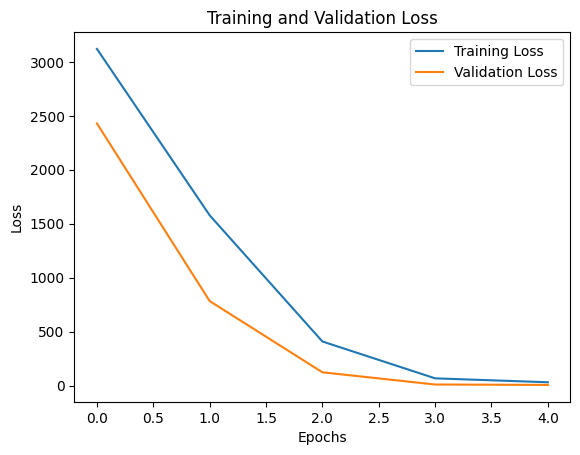

Model saved successfully.


In [69]:
from tensorflow.keras.layers import (
    Input, LSTM, Dense, Dropout, BatchNormalization, TimeDistributed, Concatenate, RepeatVector, Lambda
)
from tensorflow.keras.models import Model
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Define R2 Score Metric
def r2_score(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred), axis=-1)
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true, axis=-1, keepdims=True)), axis=-1)
    return 1 - (ss_res / (ss_tot + tf.keras.backend.epsilon()))

# Model Definition
def create_model(observed_seq_len, predicted_seq_len, input_features, output_features, hidden_units=128):
    """
    Create a Seq2Seq model with attention and additional dense layers for time series forecasting.

    Parameters:
    - observed_seq_len: Length of the input sequence.
    - predicted_seq_len: Length of the output sequence.
    - input_features: Number of input features.
    - output_features: Number of output features.
    - hidden_units: Number of LSTM hidden units.

    Returns:
    - model: Compiled Keras model.
    """

    # Encoder
    encoder_inputs = Input(shape=(observed_seq_len, input_features), name="encoder_inputs")
    encoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True, name="encoder_lstm")
    encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs)

    # Attention Layer
    attention = tf.keras.layers.Attention(name="attention_layer")
    attention_context = attention([encoder_outputs, encoder_outputs])
    attention_context = Lambda(lambda x: tf.reduce_mean(x, axis=1), name="summarize_attention")(attention_context)
    context_repeated = RepeatVector(predicted_seq_len)(attention_context)

    # Decoder
    decoder_inputs = Input(shape=(predicted_seq_len, input_features), name="decoder_inputs")
    decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True, name="decoder_lstm")
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=[encoder_state_h, encoder_state_c])

    # Merge attention context with decoder outputs
    merged_context = Concatenate(axis=-1)([decoder_outputs, context_repeated])

    # Dense Layers for Complexity
    dense_layer_1 = TimeDistributed(Dense(hidden_units * 2, activation="relu"), name="dense_layer_1")(merged_context)
    dense_layer_1 = Dropout(0.4, name="dropout_1")(dense_layer_1)
    dense_layer_1 = BatchNormalization(name="batch_norm_1")(dense_layer_1)

    dense_layer_2 = TimeDistributed(Dense(hidden_units, activation="relu"), name="dense_layer_2")(dense_layer_1)
    dense_layer_2 = Dropout(0.4, name="dropout_2")(dense_layer_2)
    dense_layer_2 = BatchNormalization(name="batch_norm_2")(dense_layer_2)

    dense_layer_3 = TimeDistributed(Dense(hidden_units // 2, activation="relu"), name="dense_layer_3")(dense_layer_2)
    dense_layer_3 = Dropout(0.4, name="dropout_3")(dense_layer_3)
    dense_layer_3 = BatchNormalization(name="batch_norm_3")(dense_layer_3)

    # Final Output Layer
    final_outputs = TimeDistributed(Dense(output_features, activation="linear"), name="final_outputs")(dense_layer_3)

    # Model
    model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=final_outputs, name="adjusted_attention_lstm_model")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mse", metrics=["mae", r2_score])

    return model

# Parameters
observed_seq_len = 5  # Length of the input sequence
predicted_seq_len = 2  # Length of the output sequence
input_features = 7  # Number of input features (e.g., LAT, LON, SOG, Hour, Minute, Second, TimeDelta)
output_features = 3  # Number of output features (e.g., LAT, LON, SOG)
batch_size = 32
epochs = 5

# Create the model
model = create_model(
    observed_seq_len=observed_seq_len,
    predicted_seq_len=predicted_seq_len,
    input_features=input_features,
    output_features=output_features
)

# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Train the Model
history = model.fit(
    [train_enc_inputs, train_dec_inputs],
    train_targets,
    validation_data=([val_enc_inputs, val_dec_inputs], val_targets),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[lr_scheduler, early_stopping]
)

# Evaluate the Model
metrics = model.evaluate([test_enc_inputs, test_dec_inputs], test_targets)
test_loss = metrics[0]  # Loss is the first metric
test_mae = metrics[1]   # MAE is the second metric
test_r2 = metrics[2]    # R2 Score is the third metric

print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")
print(f"Test R2 Score: {test_r2}")

# Plot Training and Validation Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Save the Model
model.save("adjusted_attention_lstm_model.h5")
print("Model saved successfully.")




### Seq2Seq model for probabilistic forecasting

In [22]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Dropout, Attention, Bidirectional, Add, RepeatVector, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
import numpy as np

def create_advanced_probabilistic_seq2seq(input_seq_len, output_seq_len, input_dim, output_dim, latent_dim):
    """
    Advanced Probabilistic Seq2Seq Model for Time Series Forecasting.

    Parameters:
    - input_seq_len: Length of the input sequences.
    - output_seq_len: Length of the output sequences.
    - input_dim: Number of features in the input data.
    - output_dim: Number of features in the output data.
    - latent_dim: Number of units in the LSTM layers.

    Returns:
    - model: Compiled Keras model.
    """
    # Encoder
    encoder_inputs = Input(shape=(input_seq_len, input_dim), name="encoder_inputs")
    encoder_lstm = Bidirectional(
        LSTM(latent_dim, return_sequences=True, return_state=True), name="bidirectional_encoder"
    )
    encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_lstm(encoder_inputs)

    # Combine forward and backward states
    state_h = Concatenate()([forward_h, backward_h])
    state_c = Concatenate()([forward_c, backward_c])

    # Attention Mechanism
    attention_layer = Attention(name="attention_layer")
    attention_context = attention_layer([encoder_outputs, encoder_outputs])
    attention_context = Lambda(lambda x: tf.reduce_mean(x, axis=1), name="summarize_attention")(attention_context)
    attention_context_repeated = RepeatVector(output_seq_len)(attention_context)

    # Decoder
    decoder_inputs = Input(shape=(output_seq_len, input_dim), name="decoder_inputs")
    shared_lstm = LSTM(latent_dim * 2, return_sequences=True, return_state=True, name="shared_lstm")
    decoder_outputs, _, _ = shared_lstm(decoder_inputs, initial_state=[state_h, state_c])

    # Merge Attention Context with Decoder Outputs
    merged_context = Concatenate(axis=-1)([decoder_outputs, attention_context_repeated])

    # Dropout
    dropout = Dropout(0.3, name="decoder_dropout")(merged_context)

    # Output Layers for Probabilistic Forecasting
    output_mean = Dense(output_dim, activation="linear", kernel_regularizer=tf.keras.regularizers.l2(1e-4),
                        name="mean_output")(dropout)
    output_std = Dense(output_dim, activation="softplus", kernel_regularizer=tf.keras.regularizers.l2(1e-4),
                       name="std_output")(dropout)

    # Combine Outputs
    outputs = Concatenate(name="probabilistic_outputs")([output_mean, output_std])

    # Define the Model
    model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=outputs, name="advanced_probabilistic_seq2seq_model")

    # Custom Loss Function (Negative Log-Likelihood)
    def nll_loss(y_true, y_pred):
        mean = y_pred[..., :output_dim]
        std = y_pred[..., output_dim:]
        dist = tf.compat.v1.distributions.Normal(loc=mean, scale=std)
        return -tf.reduce_mean(dist.log_prob(y_true))

    # Probabilistic Evaluation Metric: CRPS
    def crps_metric(y_true, y_pred):
        mean = y_pred[..., :output_dim]
        std = y_pred[..., output_dim:]
        return tf.reduce_mean((y_true - mean)**2 / (2 * std**2) + tf.math.log(std))

    # R² Metric
    def r2_score(y_true, y_pred):
        mean = y_pred[..., :output_dim]
        ss_res = tf.reduce_sum(tf.square(y_true - mean), axis=-1)
        ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true, axis=-1, keepdims=True)), axis=-1)
        return 1 - (ss_res / (ss_tot + tf.keras.backend.epsilon()))

    # Compile the Model
    optimizer = SGD(learning_rate=0.01, momentum=0.9, clipnorm=1.0)  # Gradient clipping included
    model.compile(optimizer=optimizer, loss=nll_loss, metrics=[crps_metric, r2_score])

    return model


In [24]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Hyperparameters
input_seq_len = 5  # Input sequence length
output_seq_len = 2  # Output sequence length
latent_dim = 64  # Number of LSTM units
input_dim = len(input_features)  # Number of input features
output_dim = len(output_features)  # Number of output features

# Create the model
model = create_advanced_probabilistic_seq2seq(input_seq_len, output_seq_len, input_dim, output_dim, latent_dim)

# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1)

# Train the model
print("Training the model...")
history = model.fit(
    [train_enc_inputs, train_dec_inputs],
    train_targets,
    validation_data=([val_enc_inputs, val_dec_inputs], val_targets),
    batch_size=32,
    epochs=10,
    callbacks=[lr_scheduler, early_stopping],
    verbose=1
)




Training the model...
Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - crps_metric: 719.4022 - loss: 720.3271 - r2_score: 0.2937 - val_crps_metric: 2.8844 - val_loss: 3.8111 - val_r2_score: 0.6736 - learning_rate: 0.0100
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - crps_metric: 2.9133 - loss: 3.8406 - r2_score: 0.6937 - val_crps_metric: 2.6451 - val_loss: 3.5741 - val_r2_score: 0.8127 - learning_rate: 0.0100
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - crps_metric: 2.7872 - loss: 3.7165 - r2_score: 0.8155 - val_crps_metric: 2.6457 - val_loss: 3.5767 - val_r2_score: 0.8753 - learning_rate: 0.0100
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - crps_metric: 2.7173 - loss: 3.6490 - r2_score: 0.8698 - val_crps_metric: 2.4179 - val_loss: 3.3513 - val_r2_score: 0.9313 - learning_rate: 0.0100
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - crps_metric: 2.7169 - loss: 3.6509 - r2_score: 0.9214 - val_crps_metric: 2.4959 - val_loss: 3.4318 - val_r2_score: